In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import ghalton
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from utils import clean,to_radian,hann,res_to_rad,ax_to_w
from Bessel_Interp import generate_halton_points
from rotation_2d import rot_cost_func, imrotate
from visualize import plot_cost_func, plot_cost_func_t, plot_volume
from cost_functions import cf_ssd
from mask import sphere_mask

In [6]:
sept23_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_10.p','rb'))
sept23_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_8.p','rb'))
sept23_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_6_4.p','rb'))

In [8]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Sept_23_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()
#pickle.dump(axes_dict,open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/axes_dict.p','wb'))

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


In [125]:
def plot_volume_slice(volume, title):
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(3)
    fig.set_figwidth(10)
    slice_ = len(volume)/2
    ax[0].imshow(volume[slice_,:,:], interpolation = 'None',cmap='gray')
    ax[1].imshow(volume[:,slice_,:], interpolation = 'None',cmap='gray')
    ax[2].imshow(volume[:,:,slice_], interpolation = 'None',cmap='gray')
    plt.suptitle(title, fontsize=15)
    plt.show()
    plt.close(fig)
    

def plot_volume(volume, title):
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(3)
    fig.set_figwidth(10)
    [ax[i].imshow(volume.max(axis=i), interpolation = 'None',cmap='gray') for i in xrange(3)]
    plt.suptitle(title, fontsize=15)
    plt.show()
    plt.close(fig)

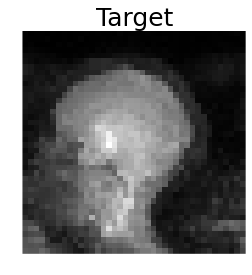

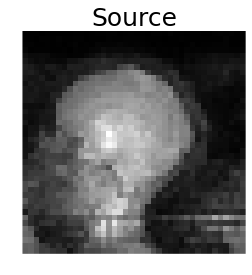

In [152]:
testVol = sept23_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
plt.imshow(testVol.max(axis=0).T, interpolation = 'None',cmap='gray',origin='center')
plt.title('Target',fontsize=25)
plt.axis('off')
plt.show()
testVol = sept23_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
plt.imshow(testVol.max(axis=0).T, interpolation = 'None',cmap='gray',origin='center')
plt.title('Source',fontsize=25)
plt.axis('off')
plt.show()

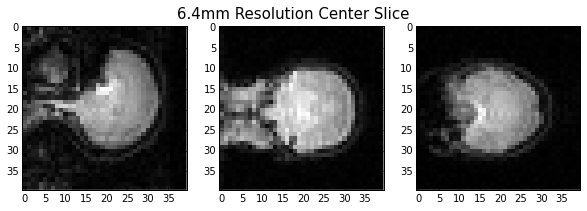

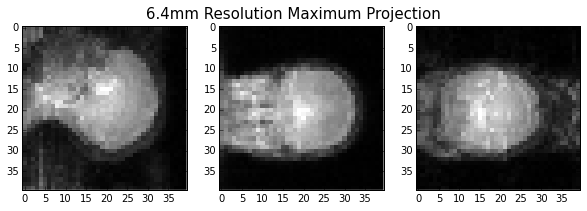

In [153]:
testVol = sept23_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
plot_volume_slice(testVol,'6.4mm Resolution Center Slice\n')
plot_volume(testVol,'6.4mm Resolution Maximum Projection\n')

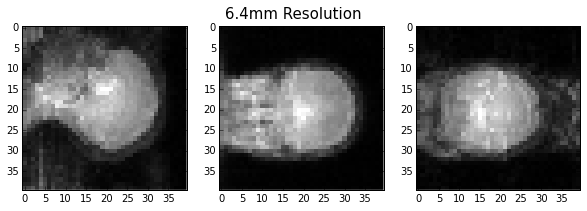

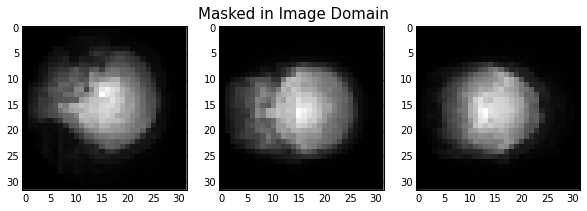

In [161]:
#testVol = sept23_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
#bess = bessel_filter_3d(testVol1)
plot_volume(testVol,'6.4mm Resolution\n')
#plot_volume(bess,'Filtered in Fourier Domain')
plot_volume(sphere_mask(bess,res_to_rad('6_4')),'Masked in Image Domain')

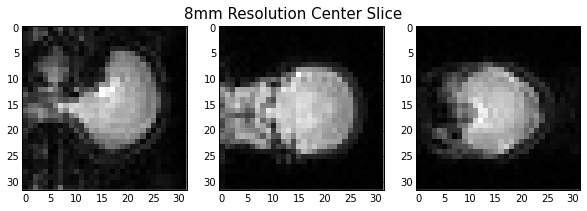

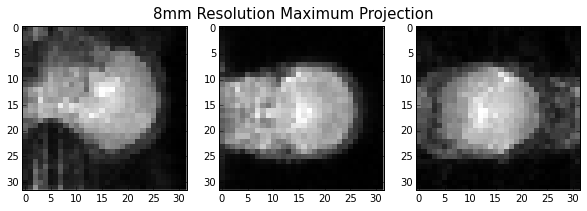

In [133]:
testVol = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
plot_volume_slice(testVol,'8mm Resolution Center Slice\n')
plot_volume(testVol,'8mm Resolution Maximum Projection\n')

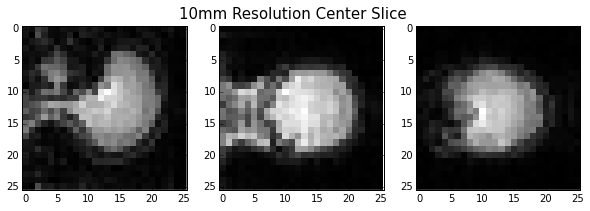

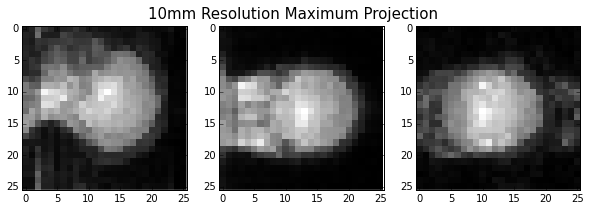

In [134]:
testVol = sept23_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
plot_volume_slice(testVol,'10mm Resolution Center Slice\n')
plot_volume(testVol,'10mm Resolution Maximum Projection\n')

# Mask in Fourier Domain

In [176]:
import scipy.ndimage as ndimage

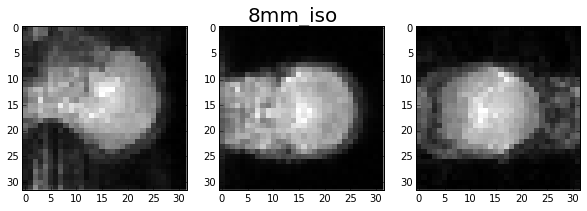

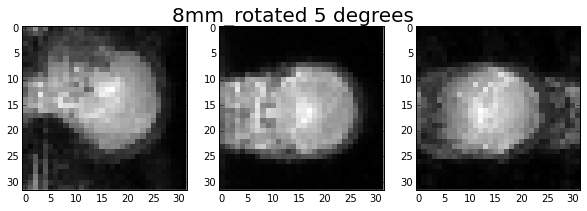

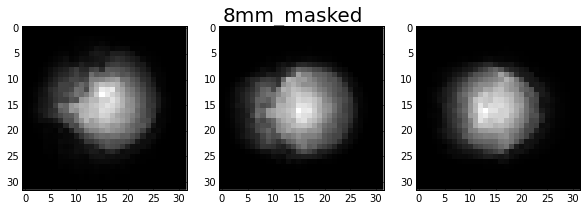

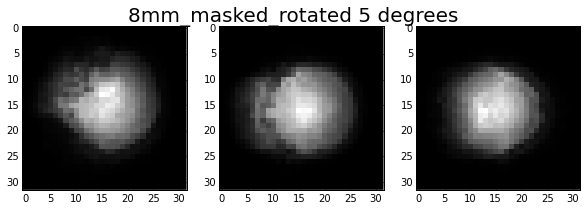

In [110]:
# Take two sample volumes
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5, 0)]

res = '8mm'
rad = res_to_rad(res)

testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

plot_volume(testVol1,'8mm','iso')
plot_volume(testVol2,'8mm','rotated 5 degrees')
plot_volume(testVol1_masked,'8mm','masked')
plot_volume(testVol2_masked,'8mm','masked_rotated 5 degrees')

In [95]:
ox,oy,oz = 15.5,15.5,15.5
x0,y0,z0 = np.ogrid[0:testVol1.shape[1], 0:testVol1.shape[0],0:testVol1.shape[2]]
x1,y1,z1 = x0,testVol1.shape[0]-y0-1,z0
x2,y2,z2 = testVol1.shape[1]-x0-1,y0,z0
x3,y3,z3 = x2,y1,z0

x4,y4,z4 = x0,y0,testVol1.shape[2]-z0-1
x5,y5,z5 = x1,y1,z4
x6,y6,z6 = x2,y2,z4
x7,y7,z7 = x3,y3,z4

In [105]:
r = len(testVol1)/2.-0.5
mask = ((x0*x0 + y0*y0 + z0*z0 > r*r)|(x1*x1 + y1*y1 + z1*z1 > r*r)|(x2*x2 + y2*y2 + z2*z2 > r*r)|(x3*x3 + y3*y3 + z3*z3 > r*r)
       |(x4*x4 + y4*y4 + z4*z4 > r*r)|(x5*x5 + y5*y5 + z5*z5 > r*r)|(x6*x6 + y6*y6 + z6*z6 > r*r)|(x7*x7 + y7*y7 + z7*z7 > r*r))
vol = testVol1.copy()
vol[~mask] = 0.

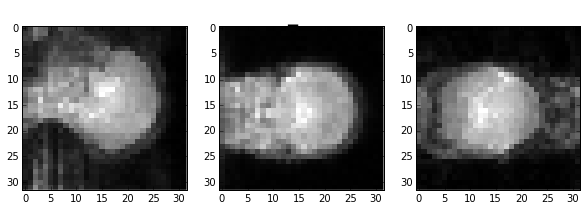

In [106]:
plot_volume(vol,'')

In [ ]:
def sphere_filter(volume, radius):
    ox = volume.shape[1]/2.-0.5
    oy = volume.shape[0]/2.-0.5
    oz = volume.shape[2]/2.-0.5
    
    r = len(volume)/2.-0.5
    
    x,y,z = np.ogrid[-ox:volume.shape[1]-ox, -oy:volume.shape[0]-oy,-oz:volume.shape[2]-oz]
    mask = (x*x + y*y + z*z <= r*r)
    vol = np.array(volume)
    vol[~mask] = 0
    origin = np.array([(x - 1.0) / 2.0 for x in volume.shape])

    mask_frequency = np.array([[[hann(np.linalg.norm(np.array([x,y,z]) - origin), radius) for x in range(volume.shape[0])] for y in range(volume.shape[1])] for z in range(volume.shape[2])])

    return mask_frequency * vol

In [204]:
# Create a disk shaped bessel filter in 2d
def bessel_filter_2d(image_org):
    image = image_org.copy()
    Ib = np.zeros(image.shape)
    s = (image.shape[0]-1)/2.
    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    xx,yy = np.meshgrid(x,y)
    for i in np.arange(-s, s+1.0):
        for j in np.arange(-s, s+1.0):
            R = np.sqrt((xx-j)**2 + (yy-i)**2)
            mask_R = (R == 0)
            Bess = np.zeros(R.shape)
            Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
            Bess[mask_R] = 0.5
            Ib[i+s,j+s] = np.sum(image*Bess)/np.sum(Bess)
    return Ib

In [157]:
# Create a disk shaped bessel filter in 3d
def bessel_filter_3d(volume_org):
    volume = volume_org.copy()
    Vb = np.zeros(volume.shape)
    s = (volume.shape[0]-1)/2.
    x = np.linspace(-s, s, volume.shape[1])
    y = np.linspace(-s, s, volume.shape[0])
    z = np.linspace(-s, s, volume.shape[2])
    xx, yy,zz = np.meshgrid(x,y,z)
    for i in np.arange(-s, s+1.0):
        for j in np.arange(-s, s+1.0):
            for k in np.arange(-s, s+1.0):

                R = np.sqrt((xx-j)**2 + (yy-i)**2 + (zz-k)**2)
                mask_R = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask_R] = ((np.sin(np.pi*R[~mask_R])/(np.pi*R[~mask_R]))-np.cos(np.pi*R[~mask_R]))/(2*np.pi*(R[~mask_R]**2))
                Bess[mask_R] = 0.5
                Vb[i+s,j+s,k+s] = np.sum(volume*Bess)/np.sum(Bess)
    return Vb

In [271]:
t0 = time.time()
Vol1_bess = bessel_filter_3d(testVol1)
print time.time()-t0

17.3260300159


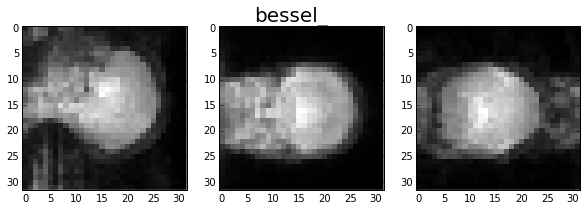

In [200]:
# Apply Bessel filter on sample volume
Vol1_bess = bessel_filter_3d(testVol1)
plot_volume(Vol1_bess,'bessel')

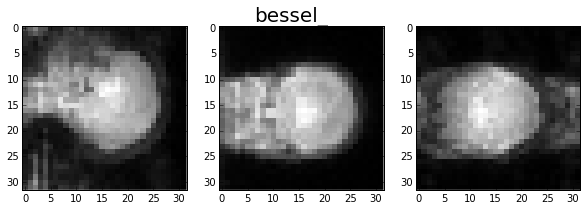

In [201]:
# Apply Bessel filter on sample volume
Vol2_bess = bessel_filter_3d(testVol2)
plot_volume(Vol2_bess,'bessel')

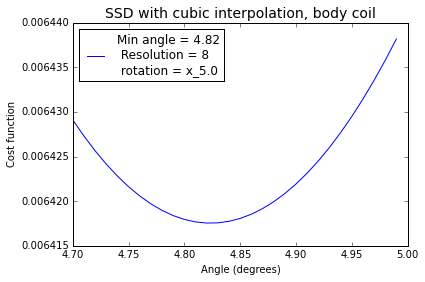

In [206]:
# Test tricubic interpolation on 8mm, x-axis rotation
res = '8'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

thetas = np.arange(4.7,5.0,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

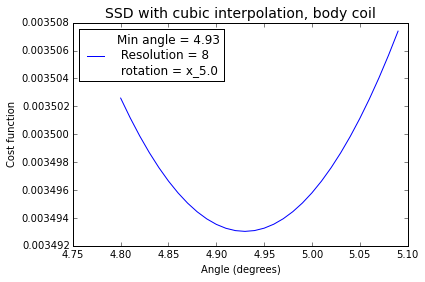

In [207]:
# Test tricubic interpolation on 8mm, x-axis rotation, with 3d bessel filter
res = '8'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

thetas = np.arange(4.8,5.1,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(Vol1_bess,rad), sphere_mask(Vol2_bess,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

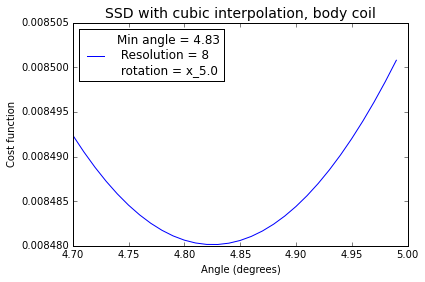

In [272]:
# Take two sample volumes
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

# Test tricubic interpolation on 8mm, x-axis rotation
res = '8'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

thetas = np.arange(4.7,5.0,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

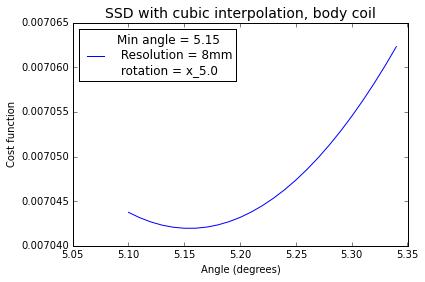

In [240]:
# Test tricubic interpolation on 8mm, x-axis rotation, with a shifted center
res = '8mm'
thetas = np.arange(5.1,5.35,0.01)
wx,wy,wz = ax_to_w(rot_ax)
trans = 5./8.
t = [wx*trans,wy*trans,wz*trans]
cost = rot_cost_func_3d(sphere_mask(translation(testVol1,t),rad), 
                        sphere_mask(translation(testVol2,t),rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

In [ ]:
Vol1_bess = bessel_filter_3d(testVol1)
Vol2_bess = bessel_filter_3d(testVol2)

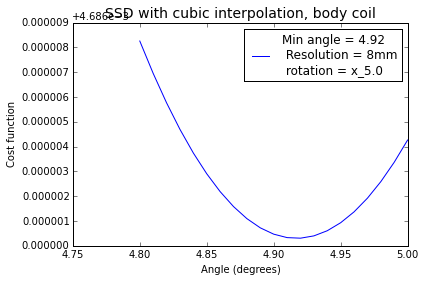

In [274]:
# Test tricubic interpolation on 8mm, x-axis rotation, filtered
res = '8mm'
thetas = np.arange(4.8,5.0,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(Vol1_bess,rad), sphere_mask(Vol2_bess,rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

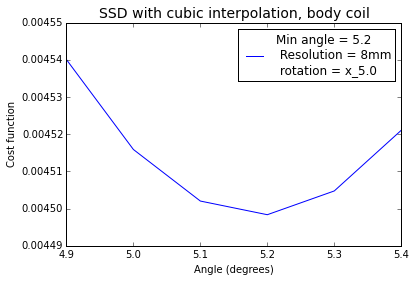

In [282]:
# Test tricubic interpolation on 8mm, x-axis rotation,filtered, with a shifted center
res = '8mm'
thetas = np.arange(4.9,5.3,0.01)
wx,wy,wz = ax_to_w(rot_ax)
trans = 5./8.
t = [wx*trans,wy*trans,wz*trans]
cost = rot_cost_func_3d(sphere_mask(translation(Vol1_bess,t),rad), 
                        sphere_mask(translation(Vol2_bess,t),rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

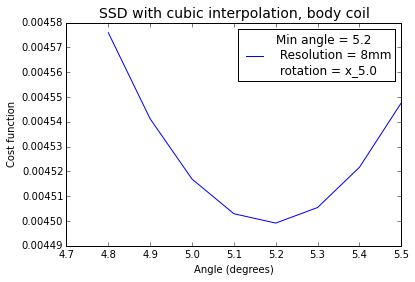

In [283]:
# Test tricubic interpolation on 8mm, x-axis rotation,filtered, with a shifted center
res = '8mm'
thetas = np.arange(4.8,5.3,0.01)
wx,wy,wz = ax_to_w(rot_ax)
trans = 5./8.
t = [wx*trans,wy*trans,wz*trans]
vol1 = bessel_filter_3d(translation(testVol1,t))
vol2 = bessel_filter_3d(translation(testVol2,t))
cost = rot_cost_func_3d(sphere_mask(vol1,rad), 
                        sphere_mask(vol2,rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

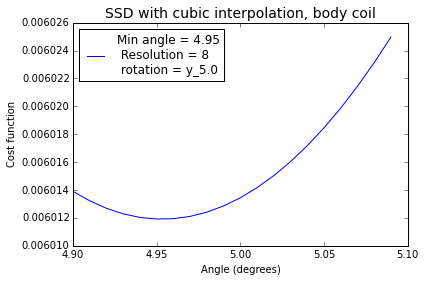

In [243]:
# Take two sample volumes
rot_ax = 'y'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

# Test tricubic interpolation on 8mm, y-axis rotation
res = '8'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

thetas = np.arange(4.9,5.1,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

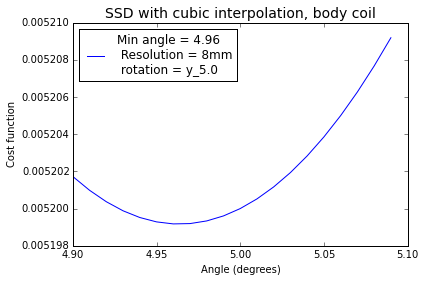

In [244]:
# Test tricubic interpolation on 8mm, y-axis rotation, with a shifted center
res = '8mm'
thetas = np.arange(4.9,5.1,0.01)
wx,wy,wz = ax_to_w(rot_ax)
trans = 5./8.
t = [wx*trans,wy*trans,wz*trans]
cost = rot_cost_func_3d(sphere_mask(translation(testVol1,t),rad), 
                        sphere_mask(translation(testVol2,t),rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

In [284]:
rot_ax = 'y'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]
Vol1_bess = bessel_filter_3d(testVol1)
Vol2_bess = bessel_filter_3d(testVol2)

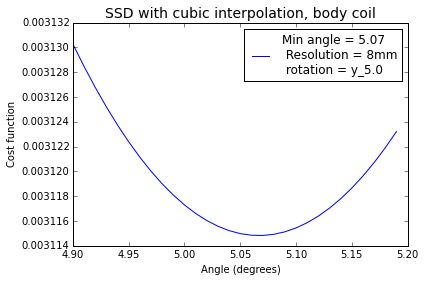

In [287]:
# Test tricubic interpolation on 8mm, x-axis rotation, filtered
res = '8mm'
thetas = np.arange(4.9,5.2,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(Vol1_bess,rad), sphere_mask(Vol2_bess,rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

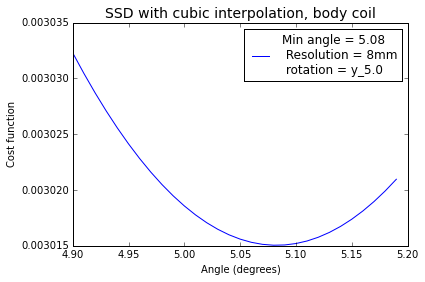

In [288]:
# Test tricubic interpolation on 8mm, x-axis rotation,filtered, with a shifted center
res = '8mm'
thetas = np.arange(4.9,5.2,0.01)
wx,wy,wz = ax_to_w(rot_ax)
trans = 5./8.
t = [wx*trans,wy*trans,wz*trans]
cost = rot_cost_func_3d(sphere_mask(translation(Vol1_bess,t),rad), 
                        sphere_mask(translation(Vol2_bess,t),rad), 
                        thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

(0.0, 0) xz xy 0_5_to_2_5


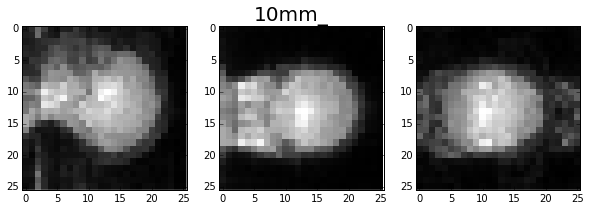

(0.0, 0) xz xy 3_0_to_5_0


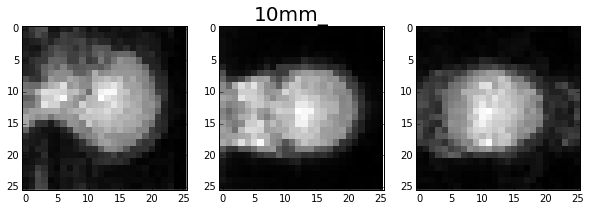

(0.5, 0) xz xy 0_5_to_2_5


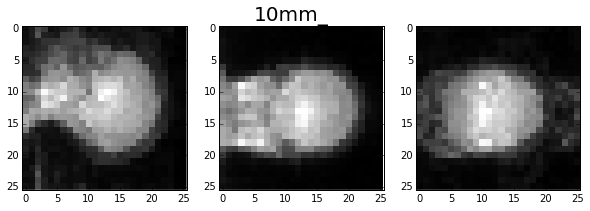

(3.0, 0) xz xy 3_0_to_5_0


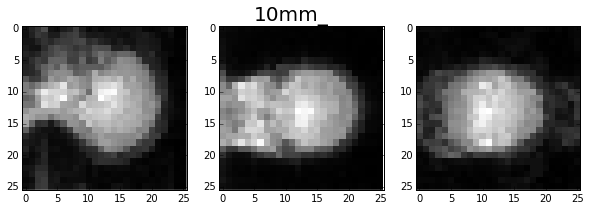

(1.0, 0) xz xy 0_5_to_2_5


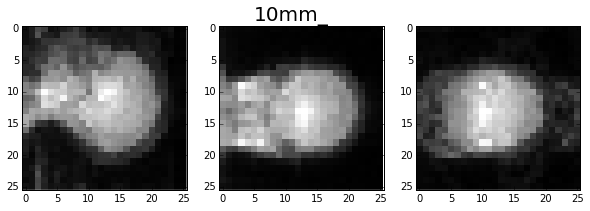

(3.5, 0) xz xy 3_0_to_5_0


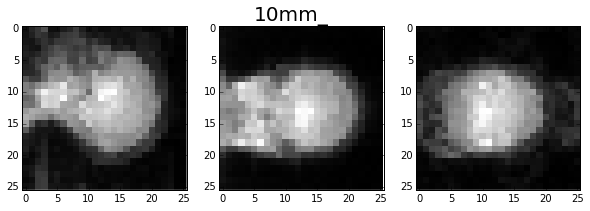

(1.5, 0) xz xy 0_5_to_2_5


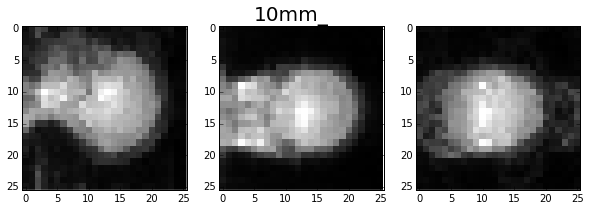

(4.0, 0) xz xy 3_0_to_5_0


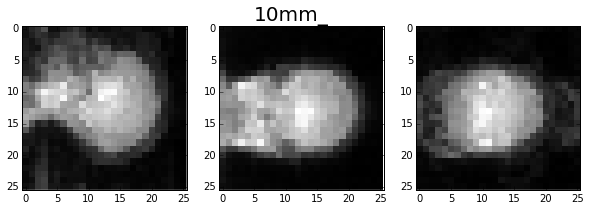

(2.0, 0) xz xy 0_5_to_2_5


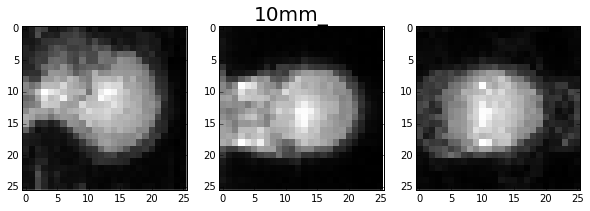

(4.5, 0) xz xy 3_0_to_5_0


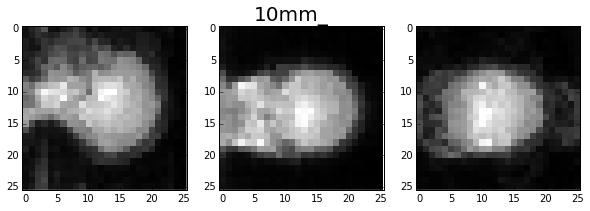

(2.5, 0) xz xy 0_5_to_2_5


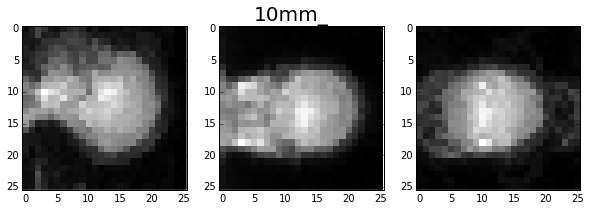

(5.0, 0) xz xy 3_0_to_5_0


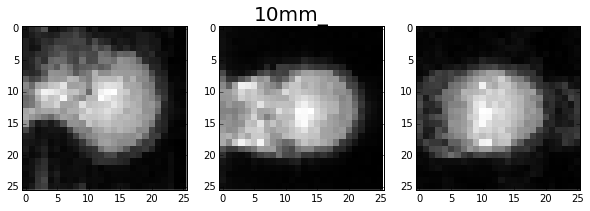

(0.0, 1) xz xy 0_5_to_2_5


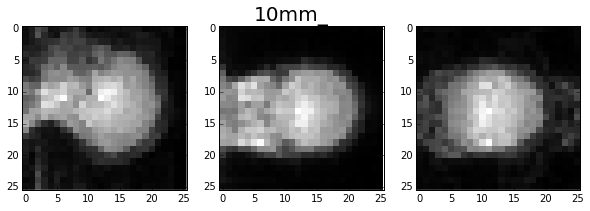

(0.0, 1) xz xy 3_0_to_5_0


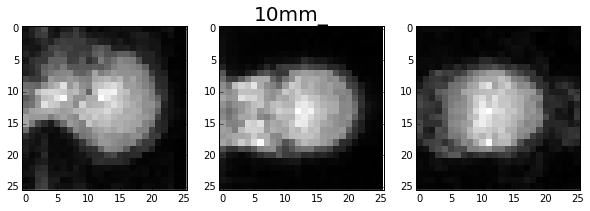

In [244]:
# 10mm
count = 0
ranges = ['0_5_to_2_5','3_0_to_5_0']
for rot_ax, trans_ax in axes_dict.iteritems():
    for rep in xrange(36):
        for rot_range in ranges:
            count += 1
            if count >= 15: break
            rot_angle = rep_to_angle(rep,rot_range)
            print str(rot_angle),rot_ax,trans_ax,rot_range
            plot_volume(sept23_dict_10[rot_ax][trans_ax][rot_range][str(rot_angle)],'10mm')

(0.0, 0) xz xy 0_5_to_2_5


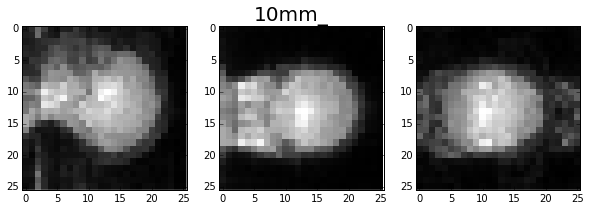

(0.0, 0) xz xy 3_0_to_5_0


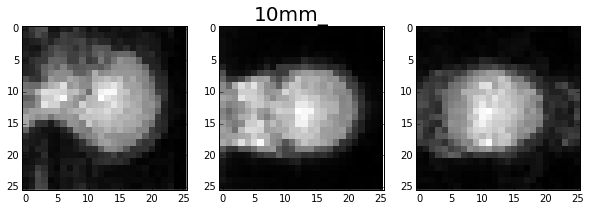

(0.5, 0) xz xy 0_5_to_2_5


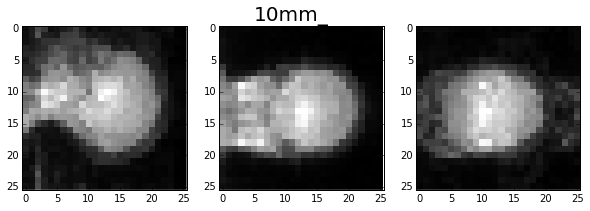

(3.0, 0) xz xy 3_0_to_5_0


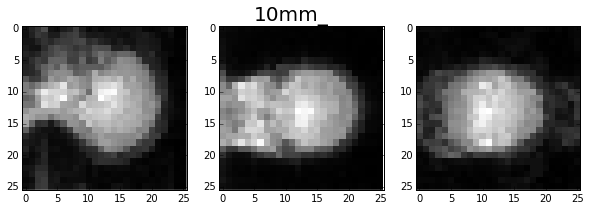

(1.0, 0) xz xy 0_5_to_2_5


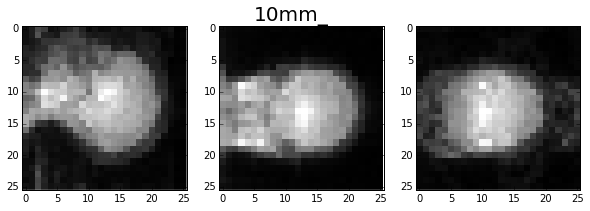

(3.5, 0) xz xy 3_0_to_5_0


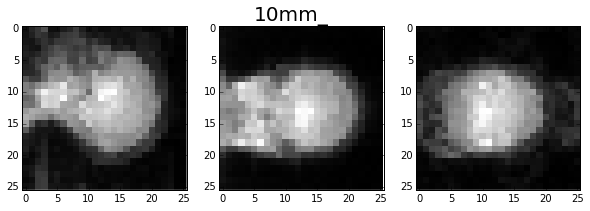

(1.5, 0) xz xy 0_5_to_2_5


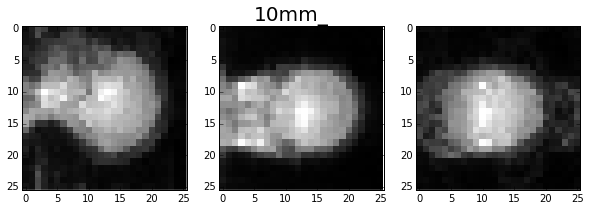

(4.0, 0) xz xy 3_0_to_5_0


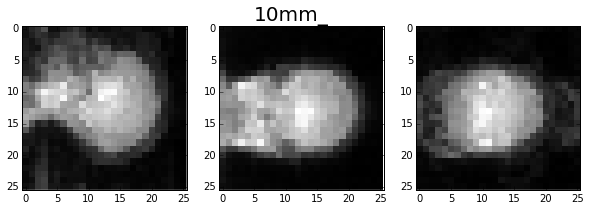

(2.0, 0) xz xy 0_5_to_2_5


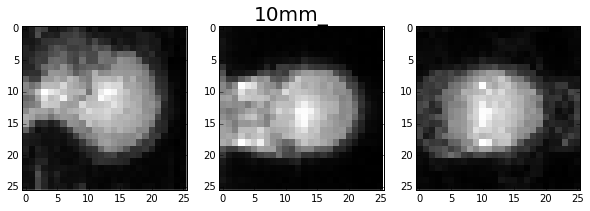

(4.5, 0) xz xy 3_0_to_5_0


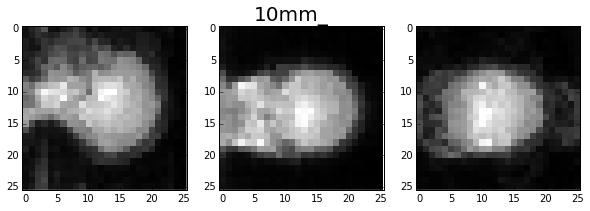

(2.5, 0) xz xy 0_5_to_2_5


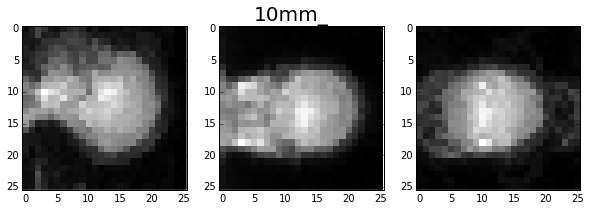

(5.0, 0) xz xy 3_0_to_5_0


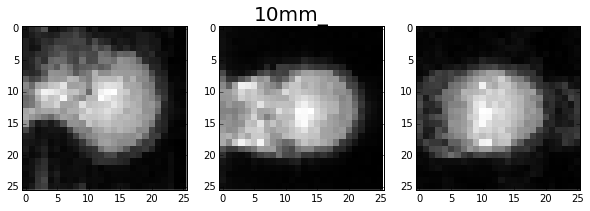

(0.0, 1) xz xy 0_5_to_2_5


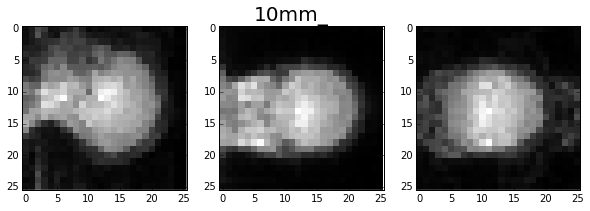

(0.0, 1) xz xy 3_0_to_5_0


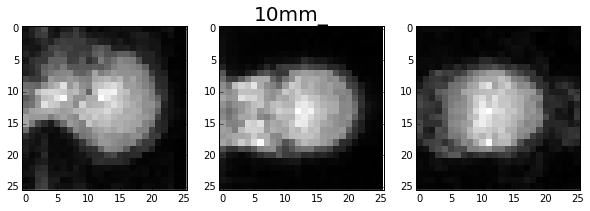

In [245]:
# 8mm
count = 0
ranges = ['0_5_to_2_5','3_0_to_5_0']
for rot_ax, trans_ax in axes_dict.iteritems():
    for rep in xrange(36):
        for rot_range in ranges:
            count += 1
            if count >= 15: break
            rot_angle = rep_to_angle(rep,rot_range)
            print str(rot_angle),rot_ax,trans_ax,rot_range
            plot_volume(sept23_dict_10[rot_ax][trans_ax][rot_range][str(rot_angle)],'10mm')

In [6]:
# function to help convert rotation axis to the unit vector of rotation
def ax_to_w(rot_ax):
    '''
    rot_ax: roation axis
    wx,wy,wz: corresponding vector of rotation for the code implementation
    '''
    if(rot_ax == 'x'): wx,wy,wz = 0,1,0
    elif(rot_ax == 'y'): wx,wy,wz = -1,0,0
    elif(rot_ax == 'z'): wx,wy,wz = 0,0,-1
    elif(rot_ax == 'xy'): wx,wy,wz = -1,1,0
    elif(rot_ax == 'xz'): wx,wy,wz = 0,1,-1
    else: wx,wy,wz = -1,0,-1
    return wx,wy,wz

In [7]:
def rep_to_angle(rep, rot_range):
    counter = rep % 6
    rotation_angle = 0.0
    translation_step = rep / 6 

    if rot_range == '0_5_to_2_5':
        if(counter != 0):
            rotation_angle = 0.5 * counter
    else: 
        # range = 3.0 to 5.0
        if(counter != 0):
            rotation_angle = 3.0 + (0.5 * (counter - 1))
    return rotation_angle, translation_step

###  Axis-Angle Rotation

If v is a vector in $R^3$ and $\boldsymbol{\omega}$ is a unit vector describing an axis of rotation about which $\mathbf{v}$ is rotated by an angle $\theta$ the Rodrigues' rotation formula to obtain the rotated vector is

$$\mathbf{v}_\mathrm{rot} = (\cos\theta) \mathbf{v}  + (\sin\theta) (\boldsymbol{\omega} \times \mathbf{v})
  +  (1 - \cos\theta) (\boldsymbol{\omega} \cdot \mathbf{v}) \boldsymbol{\omega}~$$

In [138]:
from rotation_3d import rot_cost_func_3d

Make sure the through plane rotations are correct

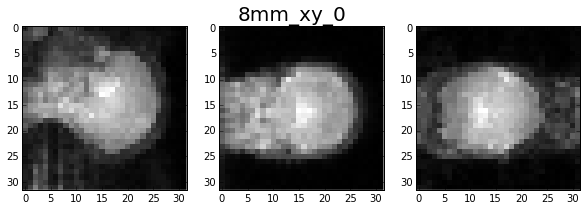

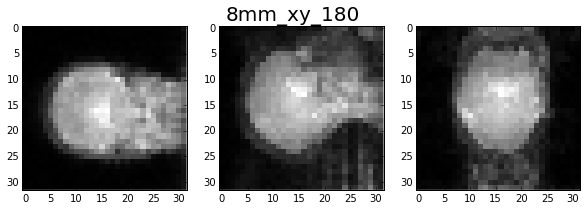

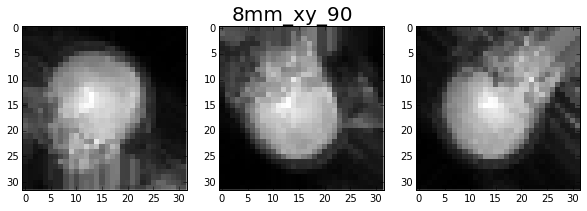

In [10]:
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
plot_volume(testVol1,'8mm','xy_0')
plot_volume(volrotate(testVol1,180,1,1,0),'8mm','xy_180')
plot_volume(volrotate(testVol1,90,1,1,0),'8mm','xy_90')

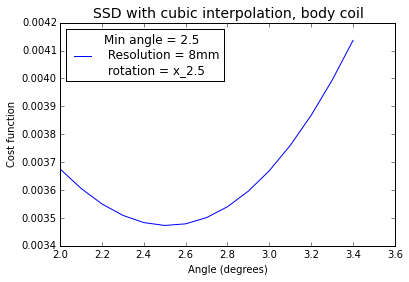

In [146]:
# Test tricubic interpolation on 8mm, x-axis rotation 
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(2.0,3.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_2.5'%rot_ax, 'body')

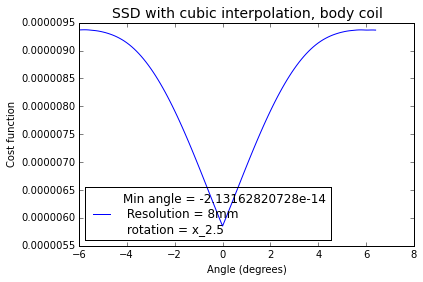

In [145]:
# Test tricubic interpolation on 8mm, x-axis rotation, with filters first
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
testVol1_filtered = ndimage.filters.gaussian_filter(testVol1,testVol1.shape)
testVol2_filtered = ndimage.filters.gaussian_filter(testVol2,testVol2.shape)
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(2.0,3.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1_filtered,rad), sphere_mask(testVol2_filtered,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'cubic','%s_2.5'%rot_ax, 'body')

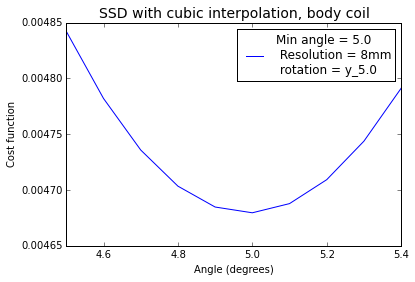

In [24]:
# Test tricubic interpolation on 8mm, y-axis rotation 
rot_ax = 'y'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(4.5,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

## Begin Debug through Plane Rotation

In [140]:
# Set up some constants for registration
res = '8'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

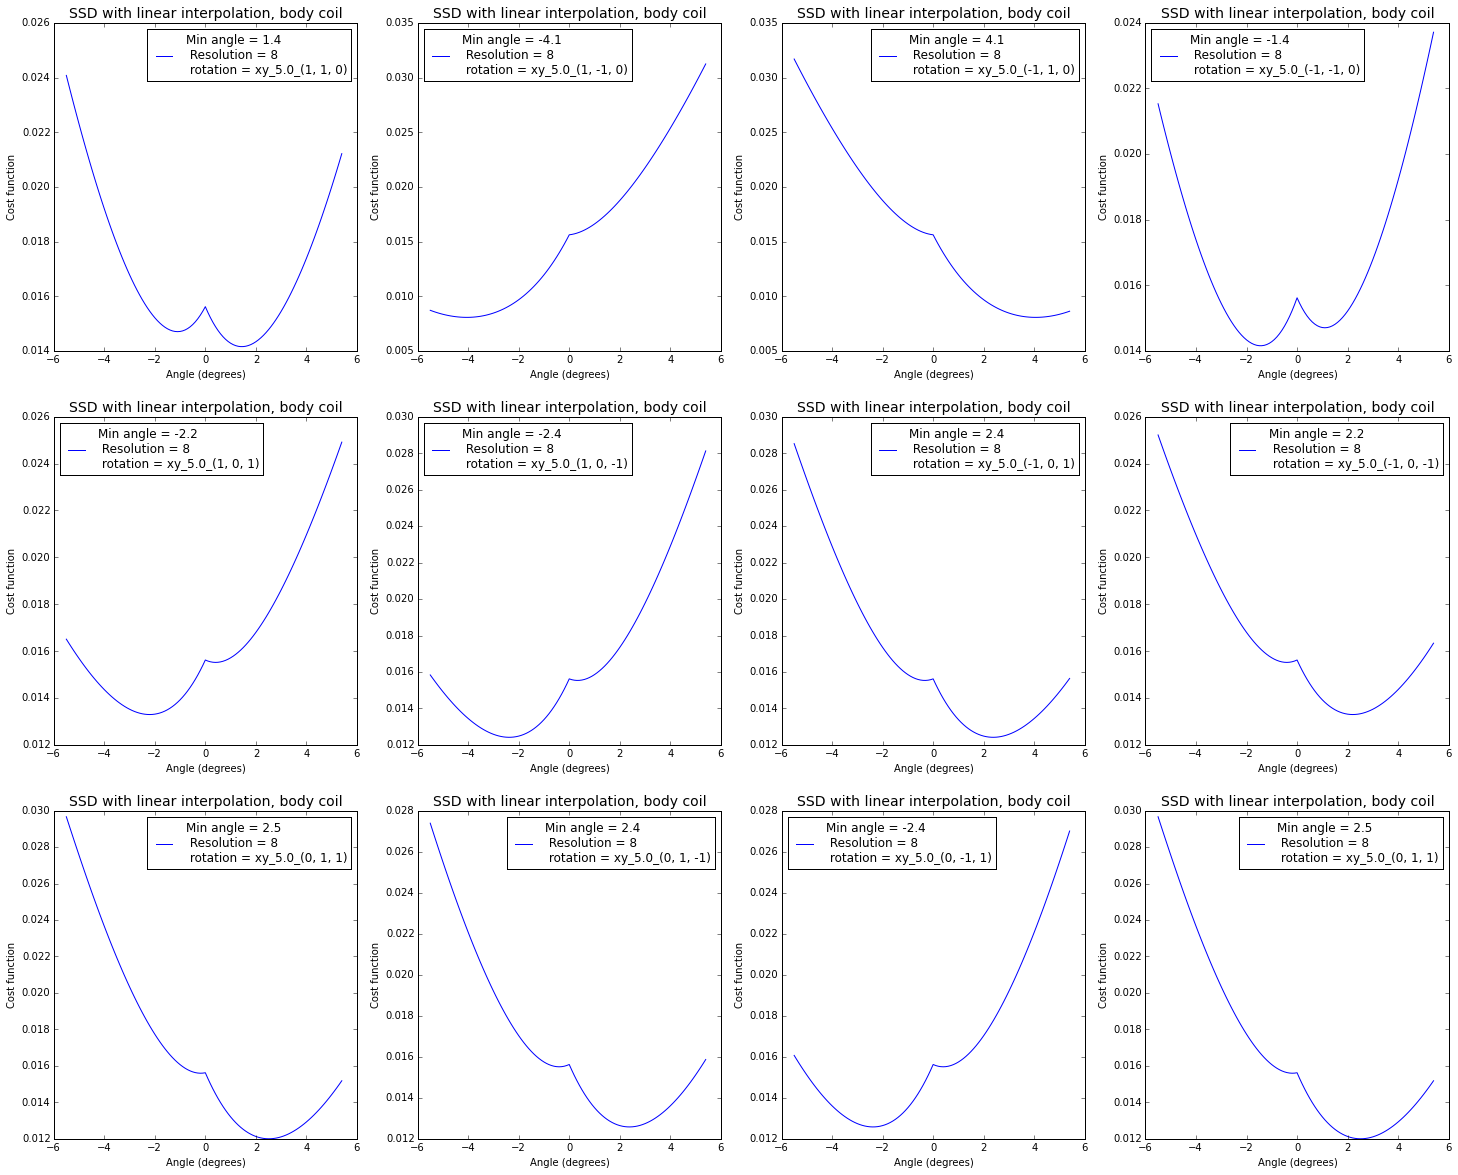

In [49]:
# Get a two samples volumes to register
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
thetas = np.arange(-5.5,5.5,0.1)
ws = [(1,1,0),(1,-1,0),(-1,1,0),(-1,-1,0),(1,0,1),(1,0,-1),(-1,0,1),(-1,0,-1),(0,1,1),(0,1,-1),(0,-1,1),(0,1,1)]
plt.figure(figsize=[25,20])
for idx,(wx,wy,wz) in enumerate(ws):
    #print wx,wy,wz
    cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'trilinear')
    plt.subplot(3,4,idx+1)
    plot_cost_func(thetas,cost,res,'linear','%s_5.0_%s'%(rot_ax,(wx,wy,wz)), 'body')
plt.show()

In [50]:
thetas = np.arange(-5.0,5.0,0.1)
print len(thetas)

100


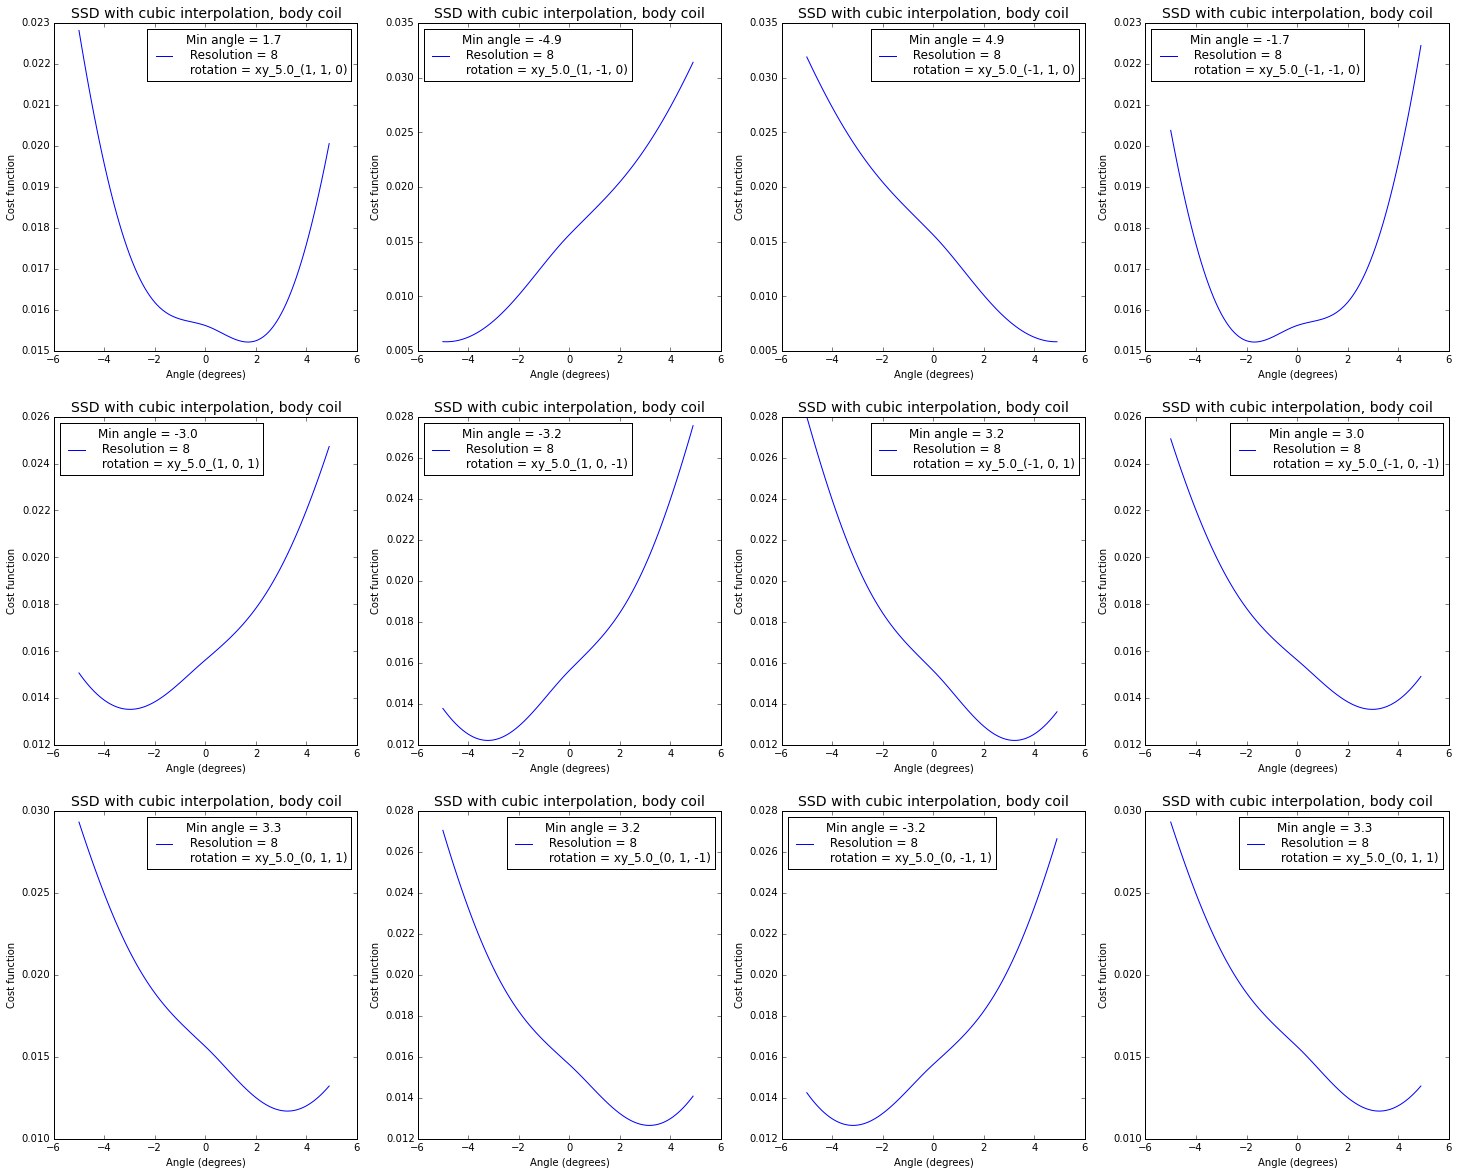

In [52]:
# Get a two samples volumes to register with Cubic
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
thetas = np.arange(-5.0,5.0,0.1)
ws = [(1,1,0),(1,-1,0),(-1,1,0),(-1,-1,0),(1,0,1),(1,0,-1),(-1,0,1),(-1,0,-1),(0,1,1),(0,1,-1),(0,-1,1),(0,1,1)]
plt.figure(figsize=[25,20])
for idx,(wx,wy,wz) in enumerate(ws):
    #print wx,wy,wz
    cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, 
                            wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
    plt.subplot(3,4,idx+1)
    plot_cost_func(thetas,cost,res,'cubic','%s_5.0_%s'%(rot_ax,(wx,wy,wz)), 'body')
plt.show()

1 1 0


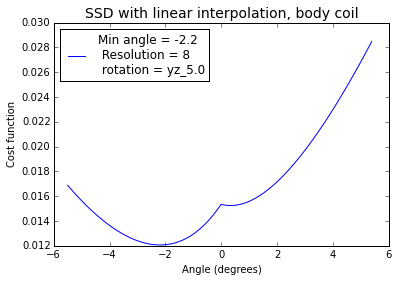

1 -1 0


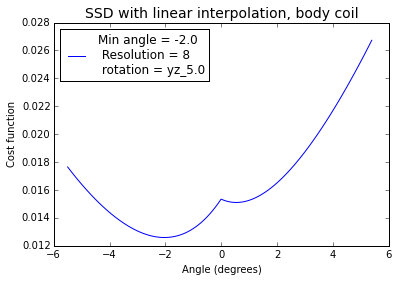

-1 1 0


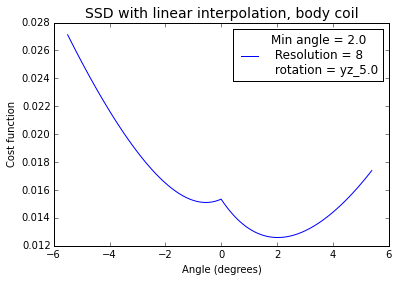

1 0 1


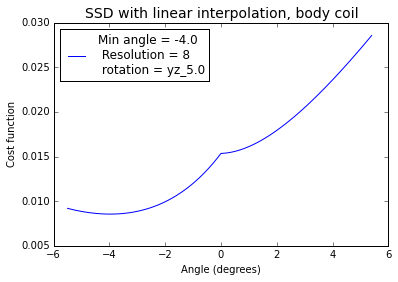

1 0 -1


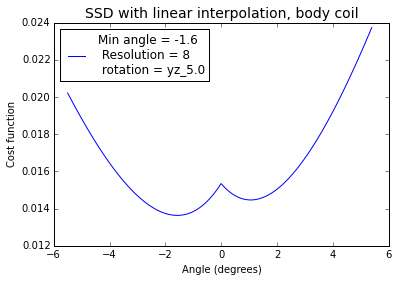

-1 0 1


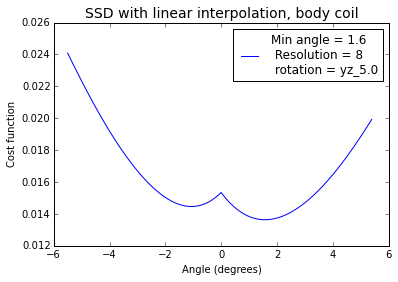

0 1 1


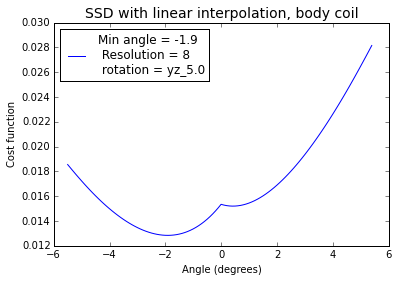

0 1 -1


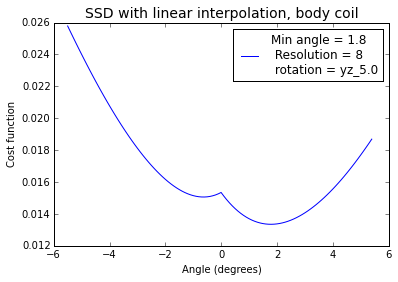

0 -1 1


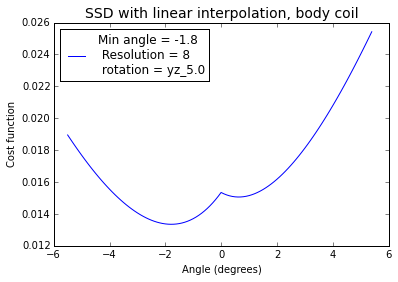

In [30]:
# Get a two samples volumes to register
rot_ax = 'yz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
thetas = np.arange(-5.5,5.5,0.1)
ws = [(1,1,0),(1,-1,0),(-1,1,0),(1,0,1),(1,0,-1),(-1,0,1),(0,1,1),(0,1,-1),(0,-1,1)]
for wx,wy,wz in ws:
    print wx,wy,wz
    cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'trilinear')
    plot_cost_func(thetas,cost,res,'linear','%s_5.0'%rot_ax, 'body')
    plt.show()

1 1 0


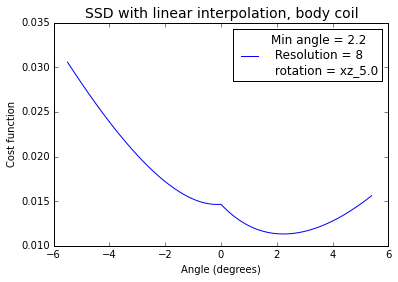

1 -1 0


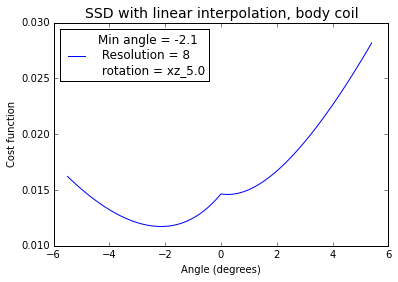

-1 1 0


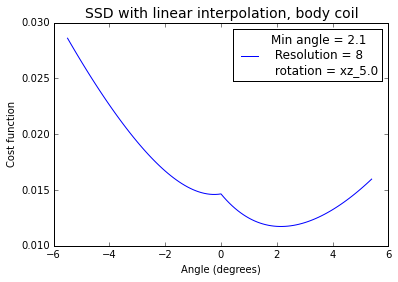

1 0 1


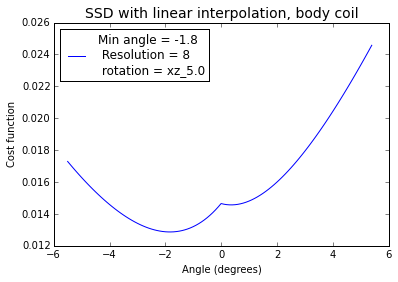

1 0 -1


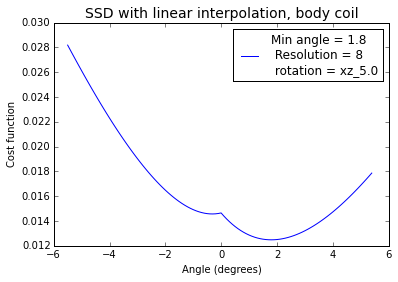

-1 0 1


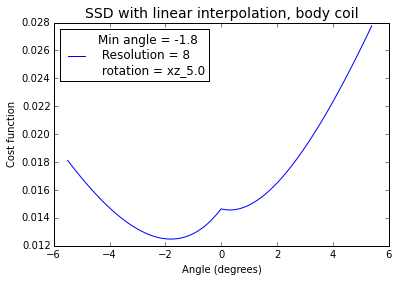

0 1 1


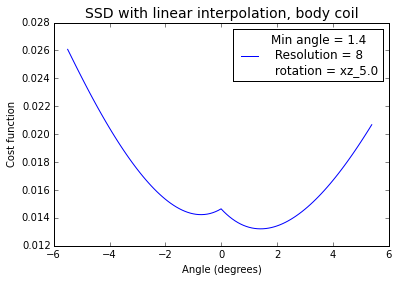

0 1 -1


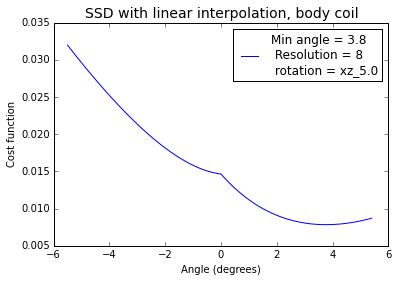

0 -1 1


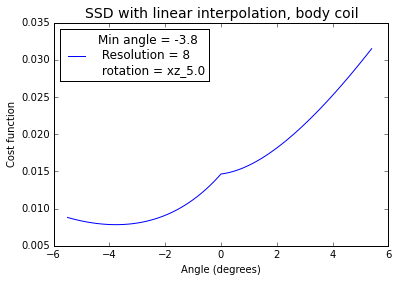

In [31]:
# Get a two samples volumes to register
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
thetas = np.arange(-5.5,5.5,0.1)
ws = [(1,1,0),(1,-1,0),(-1,1,0),(1,0,1),(1,0,-1),(-1,0,1),(0,1,1),(0,1,-1),(0,-1,1)]
for wx,wy,wz in ws:
    print wx,wy,wz
    cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'trilinear')
    plot_cost_func(thetas,cost,res,'linear','%s_5.0'%rot_ax, 'body')
    plt.show()

In [ ]:
# Test tricubic interpolation on 8mm, xz-axis rotation 
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(4.0,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

## End Debug Through Plane Rotation

0 1 -1


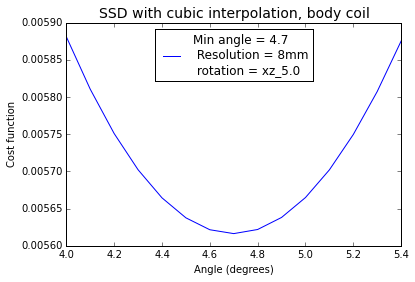

In [326]:
# Test tricubic interpolation on 8mm, xz-axis rotation 
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(4.0,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

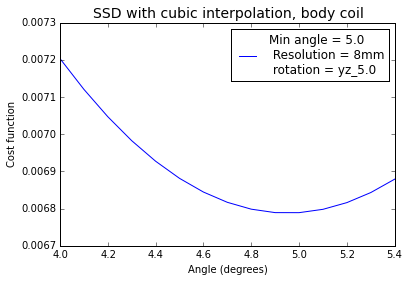

In [327]:
# Test tricubic interpolation on 8mm, yz-axis rotation 
rot_ax = 'yz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(4.0,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

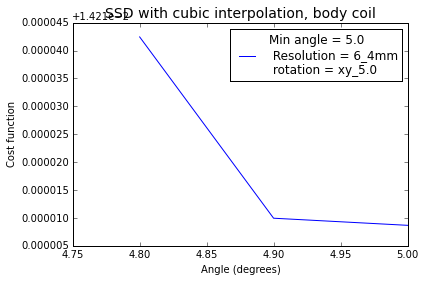

In [55]:
# Test tricubic interpolation on 6.4mm, yz-axis rotation 
# Set up some constants for registration
res = '6_4'
rad = res_to_rad(res)
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
rot_ax = 'xy'
testVol1 = sept23_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '6_4mm'
rad = res_to_rad(res)
thetas = np.arange(4.8,5.1,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

In [ ]:
# Test trilinear interpolation on 8mm, xy-axis rotation 
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(1.0,3.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_2.5'%rot_ax, 'body')

16
-1 1 0


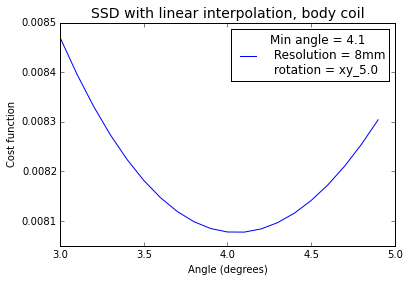

In [29]:
# Test trilinear interpolation on 8mm, xy-axis rotation 
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(3.0,5.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_5.0'%rot_ax, 'body')

16
-1 0 -1


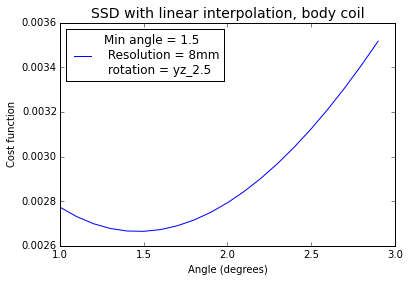

In [30]:
# Test trilinear interpolation on 8mm, yz-axis rotation 
rot_ax = 'yz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(1.0,3.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_2.5'%rot_ax, 'body')

16
-1 0 -1


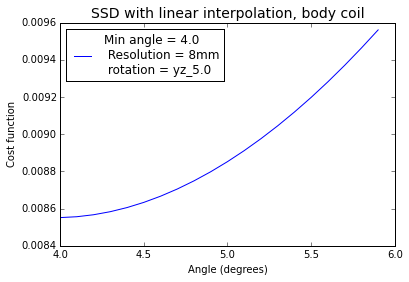

In [31]:
# Test trilinear interpolation on 8mm, yz-axis rotation 
rot_ax = 'yz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(4.0,6.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_5.0'%rot_ax, 'body')

16
0 1 -1


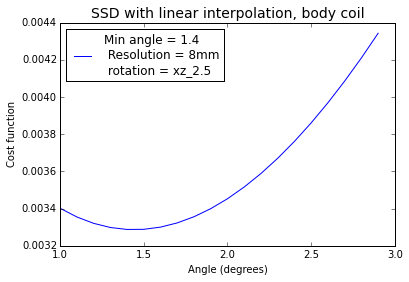

In [32]:
# Test trilinear interpolation on 8mm, xz-axis rotation 
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(1.0,3.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_2.5'%rot_ax, 'body')

16
0 1 -1


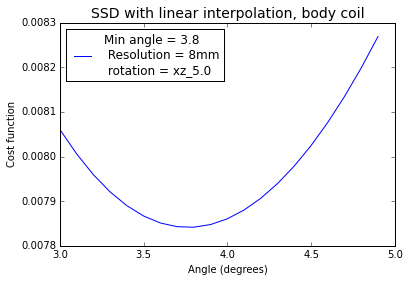

In [33]:
# Test trilinear interpolation on 8mm, xz-axis rotation 
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(3.0,5.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_5.0'%rot_ax, 'body')

### Test Multiprocess on cubic rotations

In [249]:
dict_ = sept23_dict_10.copy()
def cubic_rotations(rot_ax):
    cost_dict = {}
    rad = res_to_rad(res)
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    
    if(rot_ax == 'x'): ax = 0
    elif(rot_ax == 'y'): ax = 1
    else: ax = 2
        
    for rot_range in ranges:
        for loop in xrange(6):
            ref = rep_to_angle(loop * 6,rot_range)
            for i in xrange(1,6):
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                deg = rot_angle[0]
                thetas = np.arange(-deg-3,deg+3,0.1)
                cost_dict[rot_angle] = rot_cost_func(sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(ref)],rad),
                                                    sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(rot_angle)],rad),
                                                    thetas,axis=ax, interpolation='bicubic')
    return cost_dict

In [233]:
if __name__ == '__main__':
    keys =  axes_dict.keys()
    nproc = len(keys)
    pool = multiprocessing.Pool(processes = nproc)
    cost_dict = pool.map(cubic_rotations, keys)
    filename = '/Users/zyzdiana/Desktop/sept23_cubic_%s_rotation.p' % (rot_ax)
    pickle.dump(cost_dict,open(filename,'wb'))

In [201]:
def plot_results(cost_dict, res, interpolation):
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    for idx, rot_ax in enumerate(['x', 'y', 'z']):
        for rot_range in ranges:
            for loop in xrange(6):
                for i in xrange(1,6):
                    rep = i + loop * 6
                    rot_angle = rep_to_angle(rep,rot_range)
                    deg = rot_angle[0]
                    if interpolation == 'cubic':
                        thetas = np.arange(-deg-2,deg+2,0.01)
                    else:
                        thetas = np.arange(-deg-3,deg+3,0.01)
                    rot = '%s_%s' % (str(rot_angle[0]),rot_ax)
                    plot_cost_func(thetas,cost_dict[idx][rot_angle],res,interpolation,rot)
                    plt.show() 

In [202]:
def get_min(cost_dict, res, rot='iso'):
    # Gets the minimum search angle for all 
    min_ls = []
    axes = ['axis0','axis1','axis2']
    degrees = np.arange(0.5, 5.5, 0.5)
    for i, ax in enumerate(axes):
        for deg in degrees:
            thetas = np.arange(-deg-3,deg+3,0.01)
            for idx, coil in enumerate(['head', 'body']):
                cost = cost_dict[i][deg][coil]
                min_ls.append([deg,abs(thetas[np.argmin(cost,axis=0)]),idx])
    return np.array(min_ls)

def scatter_plot(cost_dict, res, interpolation = 'cubic'):
    colors = ['red','blue','green']
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    count = 0
    for idx, rot_ax in enumerate(['x', 'y', 'z']):
        count = 1
        for rot_range in ranges:
            for loop in xrange(6):
                for i in xrange(1,6):
                    rep = i + loop * 6
                    if(count == 1): 
                        label = rot_ax
                        count = 0
                    else: label = None
                    rot_angle = rep_to_angle(rep,rot_range)
                    deg = rot_angle[0]
                    if interpolation == 'cubic':
                        thetas = np.arange(-deg-2,deg+2,0.01)
                    else:
                        thetas = np.arange(-deg-3,deg+3,0.01)
                    cost = cost_dict[idx][rot_angle]
                    y = abs(thetas[np.argmin(cost,axis=0)])
                    plt.scatter(deg, y, s = 80, c = colors[idx],alpha = 0.6,marker='x',label = label)
    plt.plot([0,6],[0,6],c='black')
    plt.xlim([0,6])
    plt.ylim([0,6])
    plt.legend(loc=4)
    plt.title('Search Results for %s Resolution' %res)
    #plt.show()

### Test Multiprocess on trilinear rotations

In [13]:
dict_ = sept23_dict_10.copy()
res = '10'
def linear_rotations(rot_ax):
    cost_dict = {}
    rad = res_to_rad(res)
    ranges = ['0_5_to_2_5','3_0_to_5_0']

    wx,wy,wz = ax_to_w(rot_ax)

    for rot_range in ranges:
        for loop in xrange(6):
            ref = rep_to_angle(loop * 6,rot_range)
            for i in xrange(1,6):
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                deg = rot_angle[0]
                thetas = np.arange(-deg-3,deg+3,0.01)
                cost_dict[rot_angle] = rot_cost_func_3d(sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(ref)],rad),
                                                        sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(rot_angle)],rad),
                                                        thetas, wx,wy,wz,interpolation='trilinear')
    return cost_dict

In [ ]:
keys =  ['xz']
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
print keys, len(keys)
cost_dict = pool.map(linear_rotations, keys)
filename = '/Users/zyzdiana/Desktop/sept23_linear_%s_rotation.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

## Translations

In [8]:
from Bessel_Interp import generate_halton_points,circle_mask_points,bessel_rotate_arbitrary_points
from rotation_3d import trilinear_interp

In [19]:
t0 = time.time()
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)
cost_func = cf_ssd(testVol1_masked,testVol2_masked)
t1 = time.time()
print t1-t0

0.447293043137


In [25]:
t0 = time.time()
cost_func = cf_ssd(testVol1_masked,sphere_mask(testVol2,rad))
t1 = time.time()
print t1-t0

0.226400136948


In [212]:
import scipy.ndimage
def trans_cost_func_3d(vol1, vol2, trans, wx, wy, wz,order=1,mask = False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    arg: string for plot titles
    '''
    if mask:
        rad = vol1.shape[0]/2
        vol1_masked = sphere_mask(vol1,rad)
    cost_func = np.zeros([len(trans),])
    for idx, t in enumerate(trans):
        new_vol2 = scipy.ndimage.interpolation.shift(vol2,np.array([wx,wy,wz])*t,order=order, mode='wrap')
        if mask:
            cost_func[idx] = cf_ssd(sphere_mask(new_vol2,rad),vol1_masked)
        else:
            cost_func[idx] = cf_ssd(new_vol2,vol1)
    return cost_func

def halton_cost_func_t(N, vol1, vol2, t, wx, wy, wz):
    '''
    N: Number of Halton Sampling Points
    vol1: original image
    vol2: volume to be rotated
    theta: rotation by degrees
    t: list of translations to try
    '''
    cost_func = np.zeros(len(t))
    # generate Halton Sequence in the 32*32*32 grid
    pts = generate_halton_points(N * 2, 3, len(vol1) - 1)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    z1 = 31 * pts[:,2]
    for idx, th in enumerate(t):
        v2 = trilinear_interp(vol2, x1+wx*th, y1+wy*th, z1+wz*th)
        v1 = trilinear_interp(vol1, x1, y1, z1)
        cost_func[idx] = cf_ssd(v2,v1)
    return cost_func

In [213]:
def translations(res,rot_ax,order = 1,mask = False):
    if ('10' in res): dict_ = sept23_dict_10
    if ('8' in res): dict_ = sept23_dict_8
    if ('6_4' in res): dict_ = sept23_dict_6_4
    cost_dict = {}
    wx,wy,wz = ax_to_w(axes_dict[rot_ax])
    trans = np.arange(-1,1,0.01)
    for rot_range in ranges:
        for loop in xrange(1,6):
            for i in xrange(6):
                ref = rep_to_angle(i,rot_range)
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                step = rot_angle[1]
                print ref, rot_angle,step
                cost_dict[rot_angle] = trans_cost_func_3d(dict_[rot_ax][axes_dict[rot_ax]][rot_range][ref],
                                                          dict_[rot_ax][axes_dict[rot_ax]][rot_range][rot_angle],
                                                          trans, wx, wy, wz,order)
    return cost_dict

In [219]:
trans[np.argmin(cost_t)]*8.

5.1200000000000117

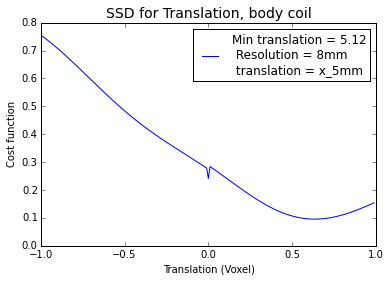

In [220]:
# Translation, cubic, no mask
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
res = '8mm'
rad = res_to_rad(res)
trans = np.arange(-1,1,0.01)
wx,wy,wz = ax_to_w(axes_dict[rot_ax])
cost_t = trans_cost_func_3d(testVol1,testVol2, trans, wx,wy,wz,order=3)
plot_cost_func_t(trans,cost_t,res,'%s_5mm'%rot_ax,'body')
plt.show()

In [214]:
from utils import rep_to_angle

In [32]:
# cost_dict_6_4 = translations('6_4','xy',3,True)
# pickle.dump(cost_dict_6_4,open('/Users/zyzdiana/Desktop/check6_4_xy.p','wb'))

(0.0, 0) (0.0, 1) 1
(0.5, 0) (0.5, 1) 1
(1.0, 0) (1.0, 1) 1
(1.5, 0) (1.5, 1) 1
(2.0, 0) (2.0, 1) 1
(2.5, 0) (2.5, 1) 1
(0.0, 0) (0.0, 2) 2
(0.5, 0) (0.5, 2) 2
(1.0, 0) (1.0, 2) 2
(1.5, 0) (1.5, 2) 2
(2.0, 0) (2.0, 2) 2
(2.5, 0) (2.5, 2) 2
(0.0, 0) (0.0, 3) 3
(0.5, 0) (0.5, 3) 3
(1.0, 0) (1.0, 3) 3
(1.5, 0) (1.5, 3) 3
(2.0, 0) (2.0, 3) 3
(2.5, 0) (2.5, 3) 3
(0.0, 0) (0.0, 4) 4
(0.5, 0) (0.5, 4) 4
(1.0, 0) (1.0, 4) 4
(1.5, 0) (1.5, 4) 4
(2.0, 0) (2.0, 4) 4
(2.5, 0) (2.5, 4) 4
(0.0, 0) (0.0, 5) 5
(0.5, 0) (0.5, 5) 5
(1.0, 0) (1.0, 5) 5
(1.5, 0) (1.5, 5) 5
(2.0, 0) (2.0, 5) 5
(2.5, 0) (2.5, 5) 5
(0.0, 0) (0.0, 1) 1
(3.0, 0) (3.0, 1) 1
(3.5, 0) (3.5, 1) 1
(4.0, 0) (4.0, 1) 1
(4.5, 0) (4.5, 1) 1
(5.0, 0) (5.0, 1) 1
(0.0, 0) (0.0, 2) 2
(3.0, 0) (3.0, 2) 2
(3.5, 0) (3.5, 2) 2
(4.0, 0) (4.0, 2) 2
(4.5, 0) (4.5, 2) 2
(5.0, 0) (5.0, 2) 2
(0.0, 0) (0.0, 3) 3
(3.0, 0) (3.0, 3) 3
(3.5, 0) (3.5, 3) 3
(4.0, 0) (4.0, 3) 3
(4.5, 0) (4.5, 3) 3
(5.0, 0) (5.0, 3) 3
(0.0, 0) (0.0, 4) 4
(3.0, 0) (3.0, 4) 4


In [51]:
axes_dict = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/axes_dict.p','rb'))
rot_axes = ['xz', 'y', 'yz', 'xy', 'x', 'z']
ax_to_idx = {}
for rot_ax in rot_axes:
    ax_to_idx[rot_ax] = rot_axes.index(rot_ax)
def scatter_plot_trans1(cost_dict, res, axes):
    colors = ['red','blue','green','orange','brown','purple']
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    count = 0
    trans = np.arange(-1,1,0.01)
    for idx, rot_ax in enumerate(axes):
        count = 1
        for rot_range in ranges:
            for loop in xrange(1,6):
                for i in xrange(6):
                    rep = i + loop * 6
                    if(count == 1): 
                        label = rot_ax+'_'+axes_dict[rot_ax]
                        count = 0
                    else: label = None
                    rot_angle = rep_to_angle(rep,rot_range)
                    step = rot_angle[1]
                    cost = cost_dict[rot_angle]
                    y = abs(trans[np.argmin(cost,axis=0)])*float(res[:-2])
                    plt.scatter(step, y, s = 80, c = colors[ax_to_idx[rot_ax]],alpha = 0.3,marker='o',lw=0,label = label)
    plt.plot([0,6],[0,6],c='black')
    plt.xlim([0,6])
    plt.ylim([0,6])
    plt.legend(loc='best')
    plt.xlabel('True Translations (mm)')
    plt.ylabel('Search Results from Registration')
    plt.title('Search Results for %s Resolution' %res)

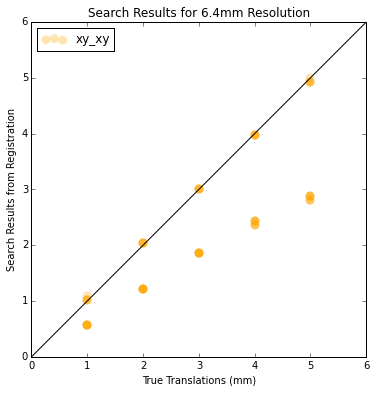

In [52]:
axes = ['xy']
plt.figure(figsize=[6,6])
scatter_plot_trans1(cost_dict_6_4, '6.4mm', axes)

In [48]:
res = '6.4mm'
ranges = ['0_5_to_2_5','3_0_to_5_0']
count = 0
trans = np.arange(-1,1,0.01)
for idx, rot_ax in enumerate(axes):
    count = 1
    for rot_range in ranges:
        for loop in xrange(1,6):
            for i in xrange(6):
                rep = i + loop * 6
                if(count == 1): 
                    label = rot_ax+'_'+axes_dict[rot_ax]
                    count = 0
                else: label = None
                rot_angle = rep_to_angle(rep,rot_range)
                step = rot_angle[1]
                cost = cost_dict_6_4[rot_angle]
                y = abs(trans[np.argmin(cost,axis=0)])*float(res[:-2])
                print step,y

1 0.576
1 1.088
1 1.024
1 1.024
1 1.024
1 1.024
2 1.216
2 2.048
2 2.048
2 2.048
2 2.048
2 2.048
3 1.856
3 3.008
3 3.008
3 3.008
3 3.008
3 3.008
4 2.368
4 3.968
4 3.968
4 3.968
4 3.968
4 3.968
5 2.816
5 4.992
5 4.928
5 4.928
5 4.928
5 4.928
1 0.576
1 0.576
1 0.576
1 0.576
1 0.576
1 0.576
2 1.216
2 1.216
2 1.216
2 1.216
2 1.216
2 1.216
3 1.856
3 1.856
3 1.856
3 1.856
3 1.856
3 1.856
4 2.368
4 2.432
4 2.432
4 2.432
4 2.432
4 2.368
5 2.816
5 2.88
5 2.88
5 2.88
5 2.88
5 2.816


In [11]:
rot_ax = 'xy'
wx,wy,wz = ax_to_w(axes_dict[rot_ax])
#trans = np.arange(-1,1,0.01)
for rot_range in ranges:
    for loop in xrange(1,6):
        for i in xrange(6):
            ref = rep_to_angle(i,rot_range)
            rep = i + loop * 6
            rot_angle = rep_to_angle(rep,rot_range)
            step = rot_angle[1]
            print ref, rot_angle

(0.0, 0) (0.0, 1)
(0.5, 0) (0.5, 1)
(1.0, 0) (1.0, 1)
(1.5, 0) (1.5, 1)
(2.0, 0) (2.0, 1)
(2.5, 0) (2.5, 1)
(0.0, 0) (0.0, 2)
(0.5, 0) (0.5, 2)
(1.0, 0) (1.0, 2)
(1.5, 0) (1.5, 2)
(2.0, 0) (2.0, 2)
(2.5, 0) (2.5, 2)
(0.0, 0) (0.0, 3)
(0.5, 0) (0.5, 3)
(1.0, 0) (1.0, 3)
(1.5, 0) (1.5, 3)
(2.0, 0) (2.0, 3)
(2.5, 0) (2.5, 3)
(0.0, 0) (0.0, 4)
(0.5, 0) (0.5, 4)
(1.0, 0) (1.0, 4)
(1.5, 0) (1.5, 4)
(2.0, 0) (2.0, 4)
(2.5, 0) (2.5, 4)
(0.0, 0) (0.0, 5)
(0.5, 0) (0.5, 5)
(1.0, 0) (1.0, 5)
(1.5, 0) (1.5, 5)
(2.0, 0) (2.0, 5)
(2.5, 0) (2.5, 5)
(0.0, 0) (0.0, 1)
(3.0, 0) (3.0, 1)
(3.5, 0) (3.5, 1)
(4.0, 0) (4.0, 1)
(4.5, 0) (4.5, 1)
(5.0, 0) (5.0, 1)
(0.0, 0) (0.0, 2)
(3.0, 0) (3.0, 2)
(3.5, 0) (3.5, 2)
(4.0, 0) (4.0, 2)
(4.5, 0) (4.5, 2)
(5.0, 0) (5.0, 2)
(0.0, 0) (0.0, 3)
(3.0, 0) (3.0, 3)
(3.5, 0) (3.5, 3)
(4.0, 0) (4.0, 3)
(4.5, 0) (4.5, 3)
(5.0, 0) (5.0, 3)
(0.0, 0) (0.0, 4)
(3.0, 0) (3.0, 4)
(3.5, 0) (3.5, 4)
(4.0, 0) (4.0, 4)
(4.5, 0) (4.5, 4)
(5.0, 0) (5.0, 4)
(0.0, 0) (0.0, 5)
(3.0, 0) (

In [ ]:
testVol1 = sept23_dict_10['z']['z'][ranges[0]]['(0.0, 0)']
testVol2 = sept23_dict_10['z']['z'][ranges[0]]['(0.0, 5)']
trans = np.arange(-1,1,0.01)
wx,wy,wz = ax_to_w('z')
for N in [100,300,500,1000,5000,10000,20000,50000]:
    cost_t = halton_cost_func_t(N, testVol1,testVol2, trans, wx,wy,wz)
    plot_cost_func_t(trans,cost_t,'10mm','z_5mm','N = %d body' %N)
    plt.show()

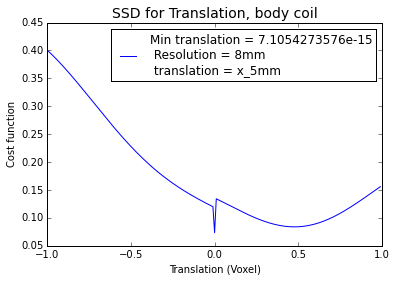

In [18]:
# Translation, cubic, no mask
rot_ax = 'x'
testVol1 = sept23_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 4)]
res = '8mm'
rad = res_to_rad(res)
trans = np.arange(-1,1,0.01)
wx,wy,wz = ax_to_w(axes_dict[rot_ax])
cost_t = trans_cost_func_3d(testVol1,testVol2, trans, wx,wy,wz,order=3)
plot_cost_func_t(trans,cost_t,res,'%s_5mm'%rot_ax,'body')
plt.show()

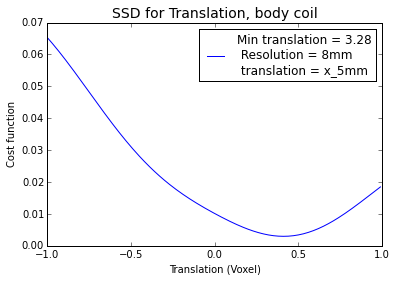

In [28]:
# Translation, cubic, no mask
rot_ax = 'x'
testVol1 = sept23_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 4)]
res = '8mm'
rad = res_to_rad(res)
trans = np.arange(-1,1,0.01)
wx,wy,wz = ax_to_w(axes_dict[rot_ax])
cost_t = trans_cost_func_3d(testVol1,testVol2, trans, wx,wy,wz,order=3,mask=True)
plot_cost_func_t(trans,cost_t,res,'%s_5mm'%rot_ax,'body')
plt.show()

16


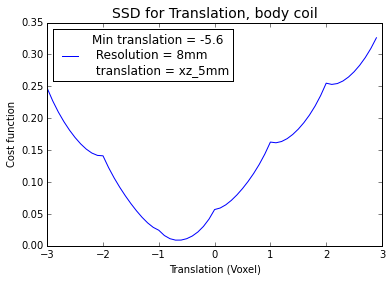

In [122]:
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
res = '8mm'
rad = res_to_rad(res)
print rad
trans = np.arange(-3,3,0.1)
wx,wy,wz = ax_to_w(axes_dict[rot_ax])
#wx,wy,wz = -1,1,0
cost_t = trans_cost_func_3d(testVol1,testVol2, trans, wx,wy,wz,mask=True)
plot_cost_func_t(trans,cost_t,res,'%s_5mm'%rot_ax,'body')
plt.show()

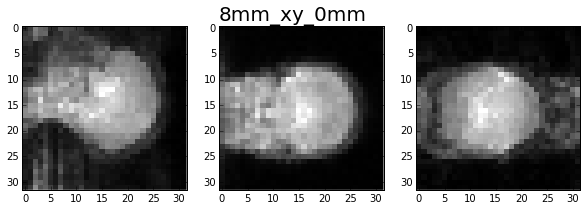

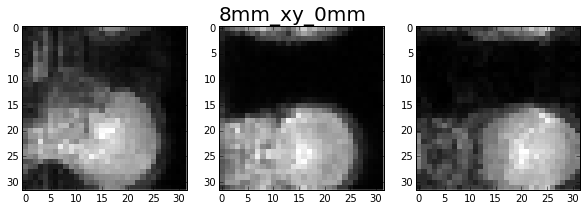

In [93]:
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
plot_volume(testVol1,'8mm','xy_0mm')
trans_testVol1 = scipy.ndimage.interpolation.shift(testVol1,[8,8,0],order=1,mode = 'wrap')
plot_volume(trans_testVol1,'8mm','xy_0mm')

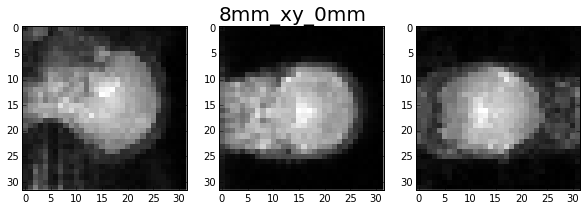

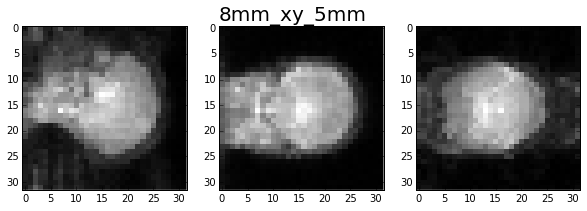

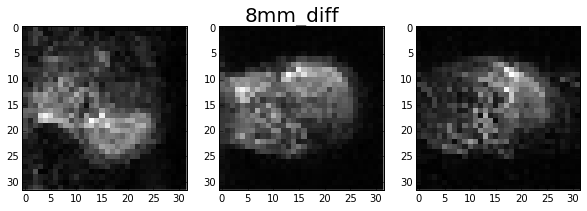

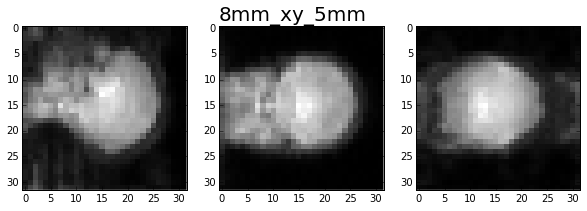

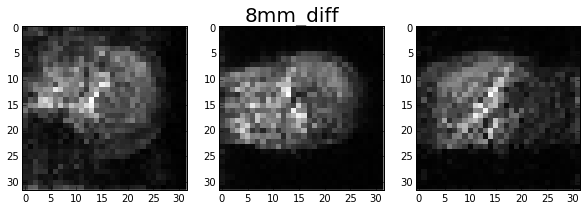

In [78]:
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
plot_volume(testVol1,'8mm','xy_0mm')
plot_volume(testVol2,'8mm','xy_5mm')
plot_volume(testVol2-testVol1,'8mm','diff')
step = 5./8.
trans_testVol2 = scipy.ndimage.interpolation.shift(testVol2,[-step,-step,0],order=1,mode = 'wrap')
plot_volume(trans_testVol2,'8mm','xy_5mm')
plot_volume(trans_testVol2-testVol2,'8mm','diff')
#plot_volume(volrotate(testVol1,180,1,1,0),'8mm','xy_180')
#plot_volume(volrotate(testVol1,90,1,1,0),'8mm','xy_90')

Test Halton Sampling on Translations

In [305]:
# Linear Translation with mask
cost_trans_linear_masked = {}
for k in axes_dict:
    print k,
    cost_trans_linear_masked[k] = translations('10mm',k,mask = True)
pickle.dump(cost_trans_linear_masked, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_linear_10_masked.p','wb'))

xz y yz xy x z


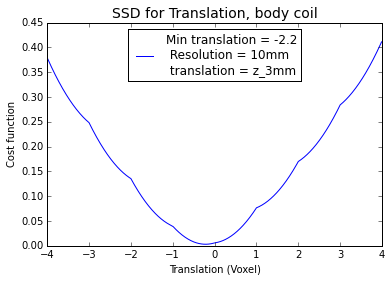

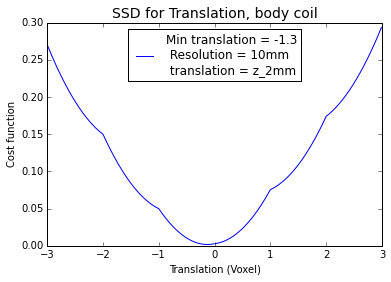

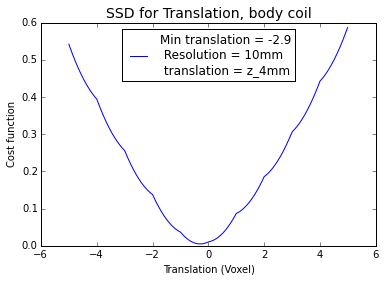

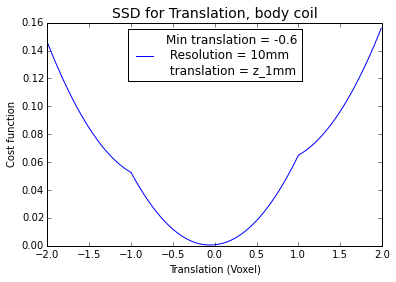

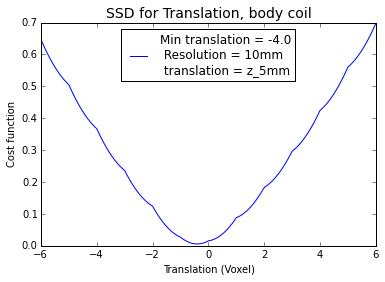

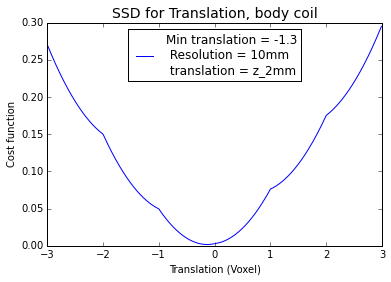

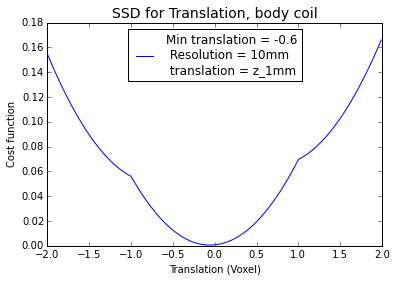

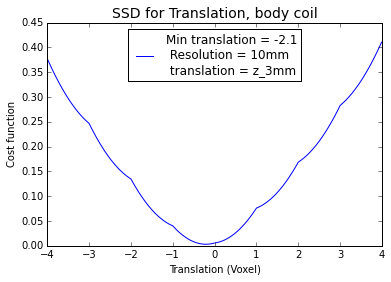

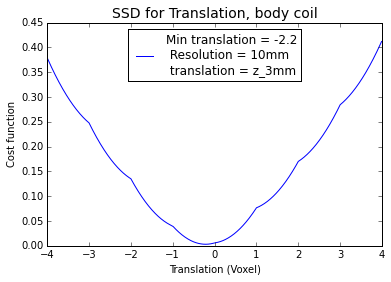

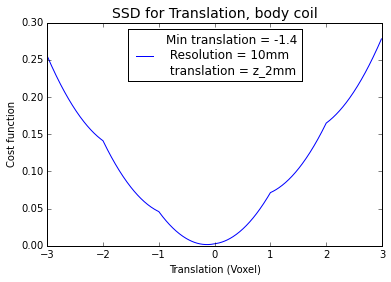

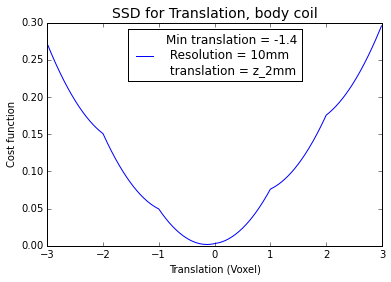

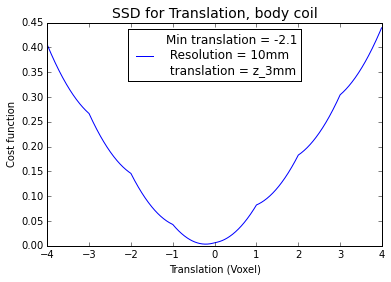

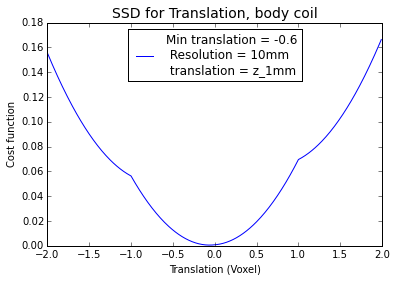

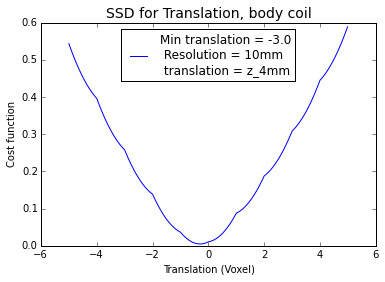

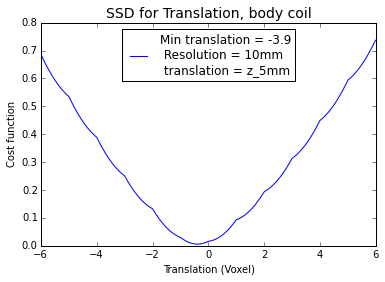

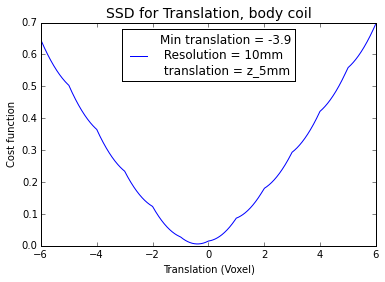

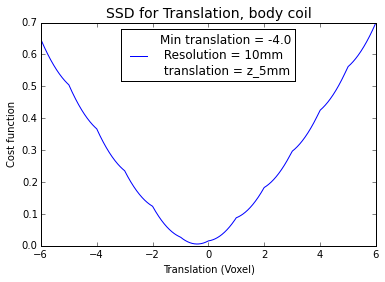

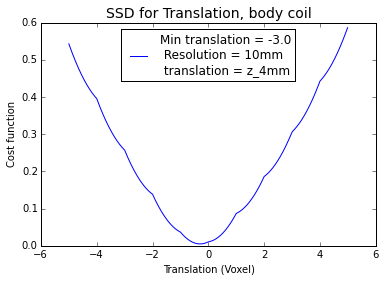

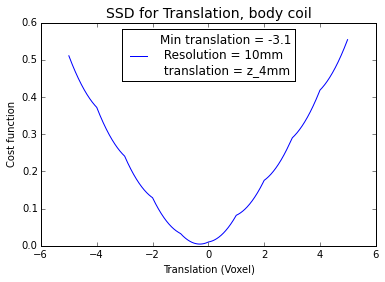

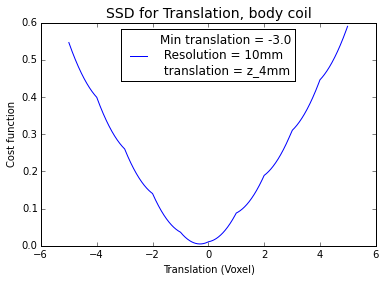

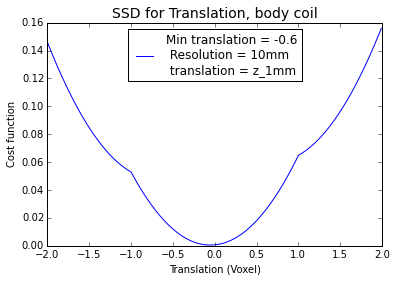

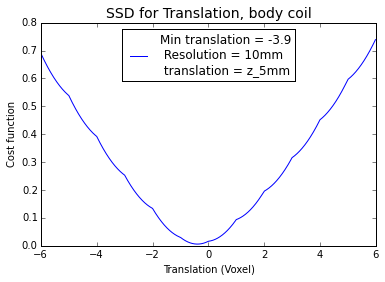

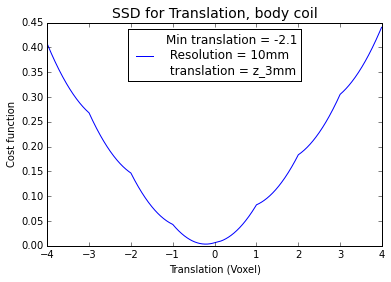

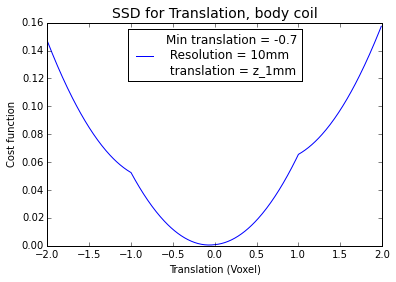

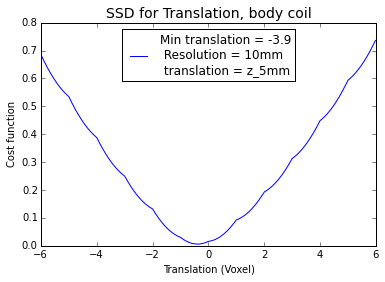

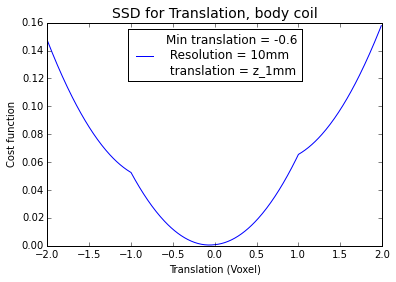

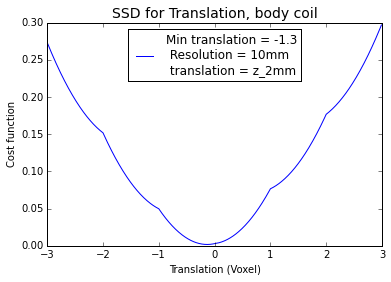

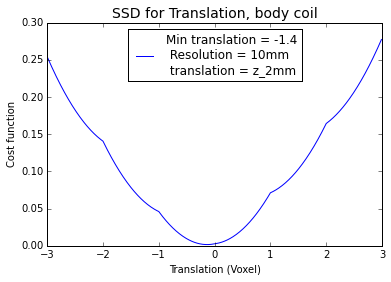

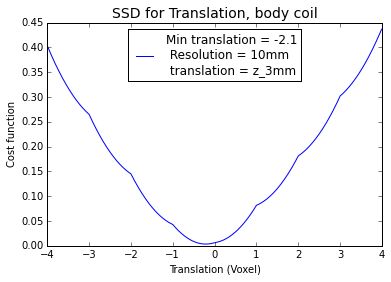

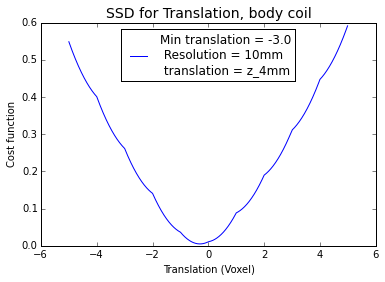

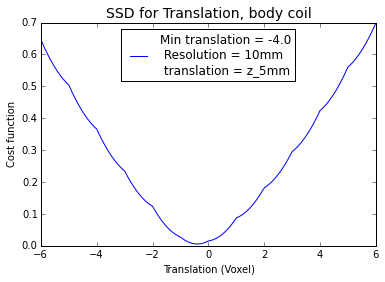

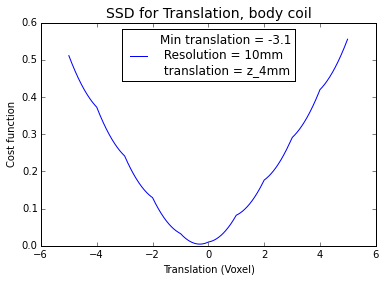

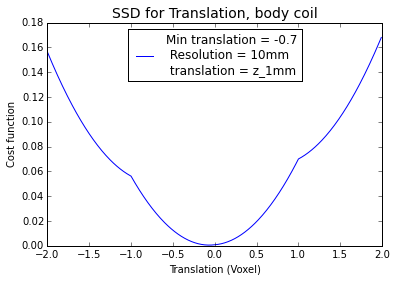

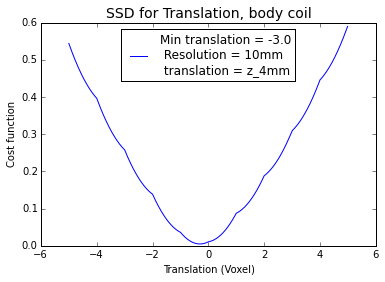

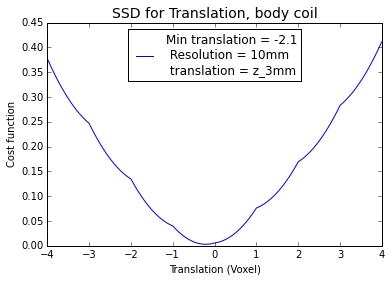

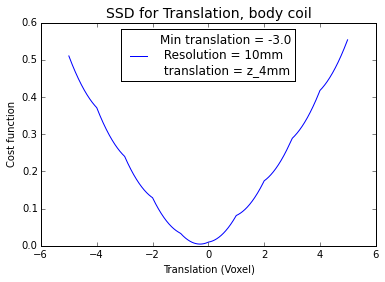

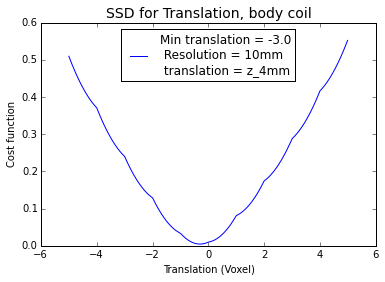

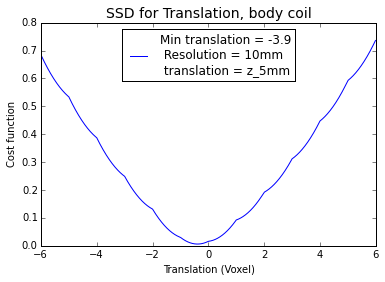

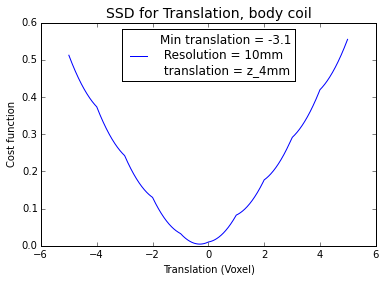

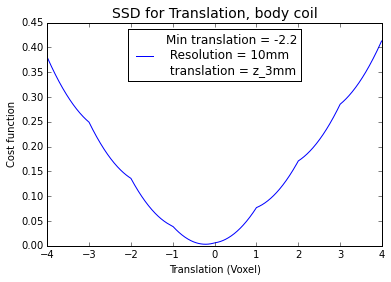

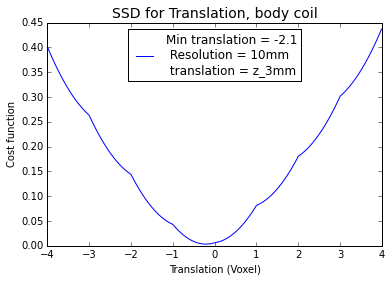

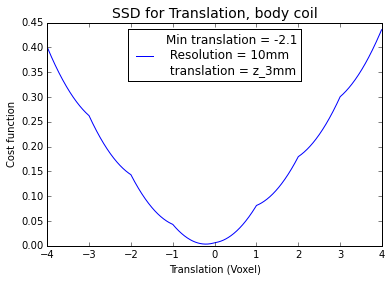

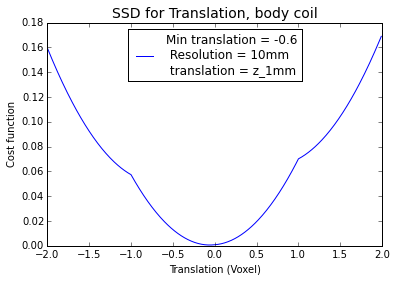

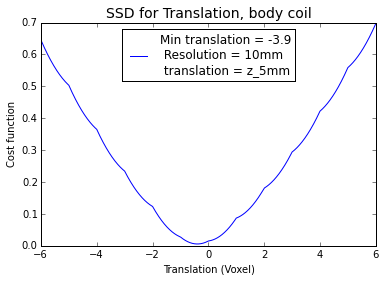

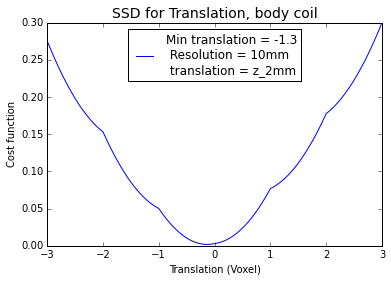

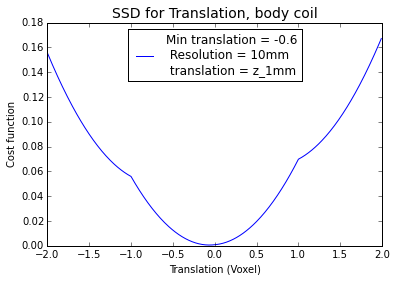

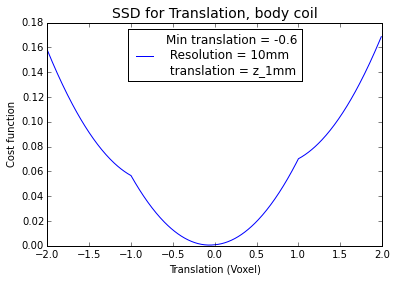

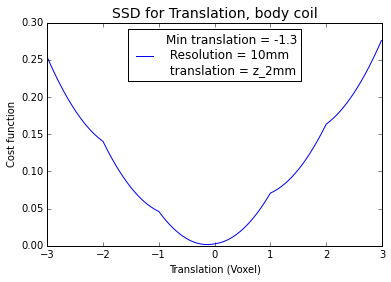

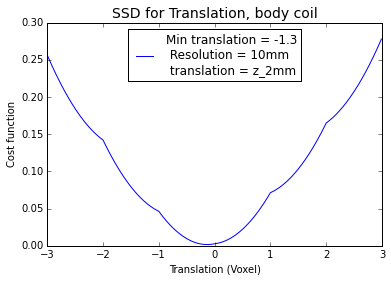

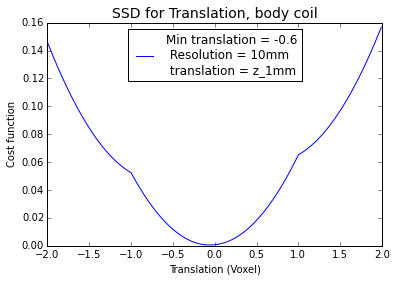

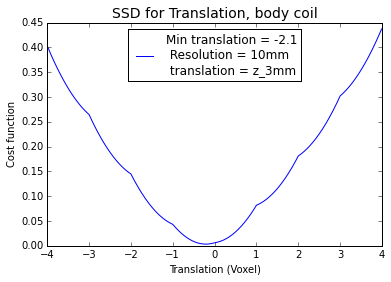

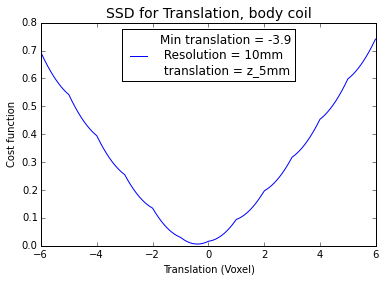

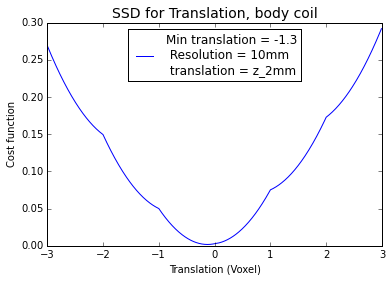

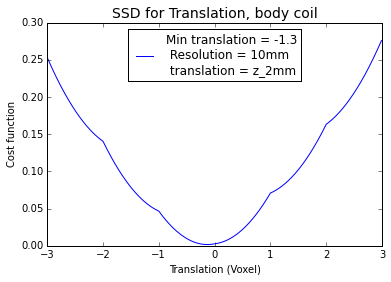

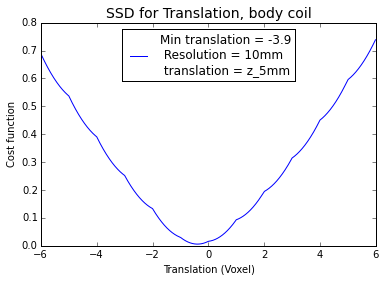

In [304]:
for k in cost_trans_linear_masked['x'].keys():
    step = k[1]
    trans = np.arange(-step-1,step+1,0.01)
    plot_cost_func_t(trans,cost_trans_linear_masked['x'][k],'10mm','z_%smm'%step,'body')
    plt.show()

In [427]:
# Linear Translation
cost_trans_linear = {}
for k in axes_dict:
    print k,
    cost_trans_linear[k] = translations('10',k)
pickle.dump(cost_trans_linear, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_linear_10.p','wb'))

xz y yz xy x z


In [191]:
# Linear Translation
cost_trans_linear = {}
for k in axes_dict:
    print k,
    cost_trans_linear[k] = translations('8',k)
pickle.dump(cost_trans_linear, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_linear_8.p','wb'))

xz y yz xy x z


In [192]:
# Linear Translation
cost_trans_linear = {}
for k in axes_dict:
    print k,
    cost_trans_linear[k] = translations('6_4',k)
pickle.dump(cost_trans_linear, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_linear_6_4.p','wb'))

xz y yz xy x z


In [193]:
# Cubic Translation
cost_trans_cubic = {}
for k in axes_dict:
    print k,
    cost_trans_cubic[k] = translations('10',k,order=3)
pickle.dump(cost_trans_cubic, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_cubic_10.p','wb'))

xz y yz xy x z


In [194]:
# Cubic Translation
cost_trans_cubic = {}
for k in axes_dict:
    print k,
    cost_trans_cubic[k] = translations('8', k, order = 3)
pickle.dump(cost_trans_cubic, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_cubic_8.p','wb'))

xz y yz xy x z


In [195]:
# Cubic Translation
cost_trans_cubic = {}
for k in axes_dict:
    print k,
    cost_trans_cubic[k] = translations('6_4', k, order = 3)
pickle.dump(cost_trans_cubic, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_cubic_6_4.p','wb'))

xz y yz xy x z


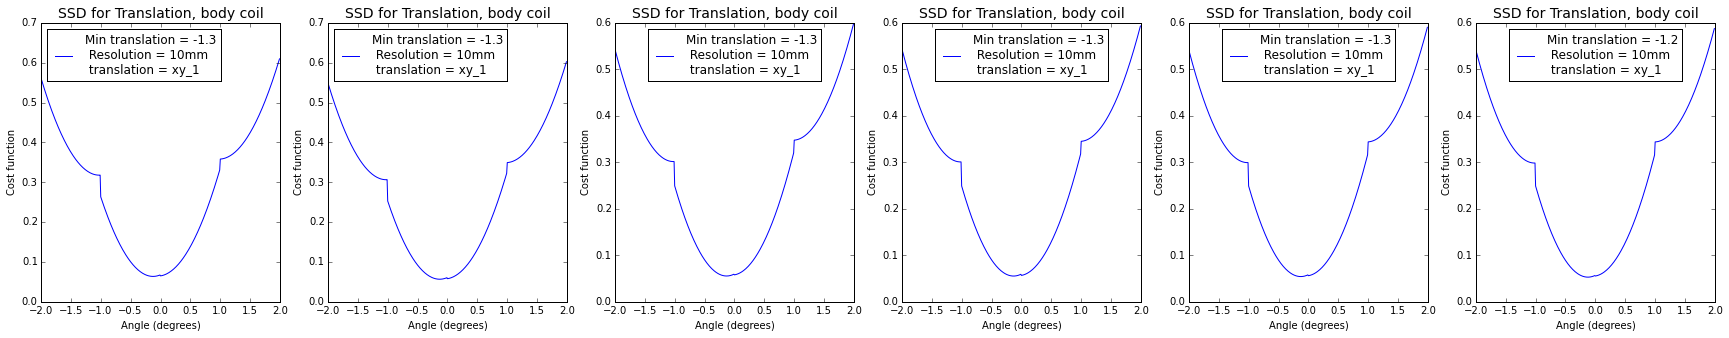

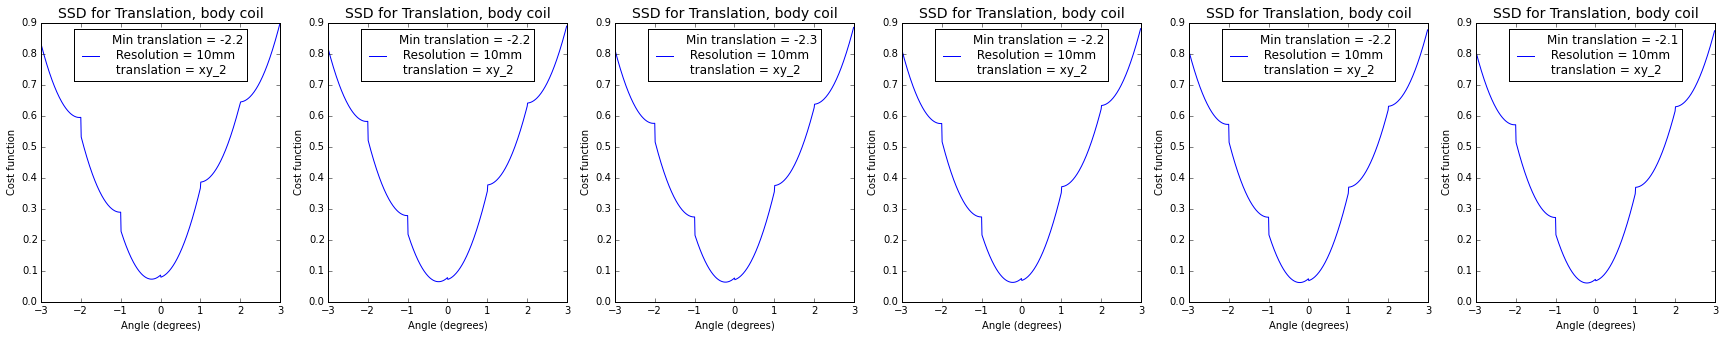

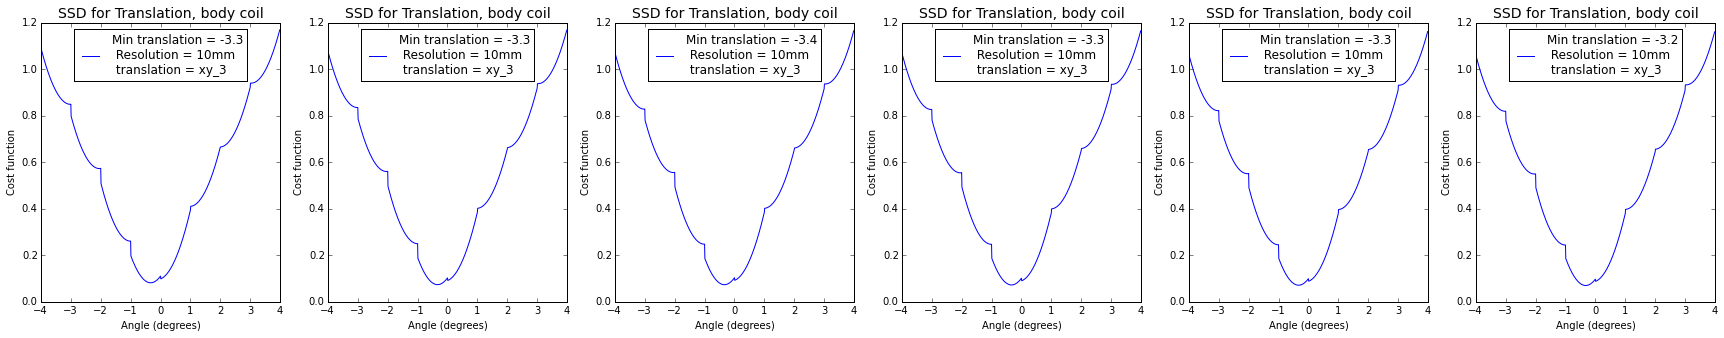

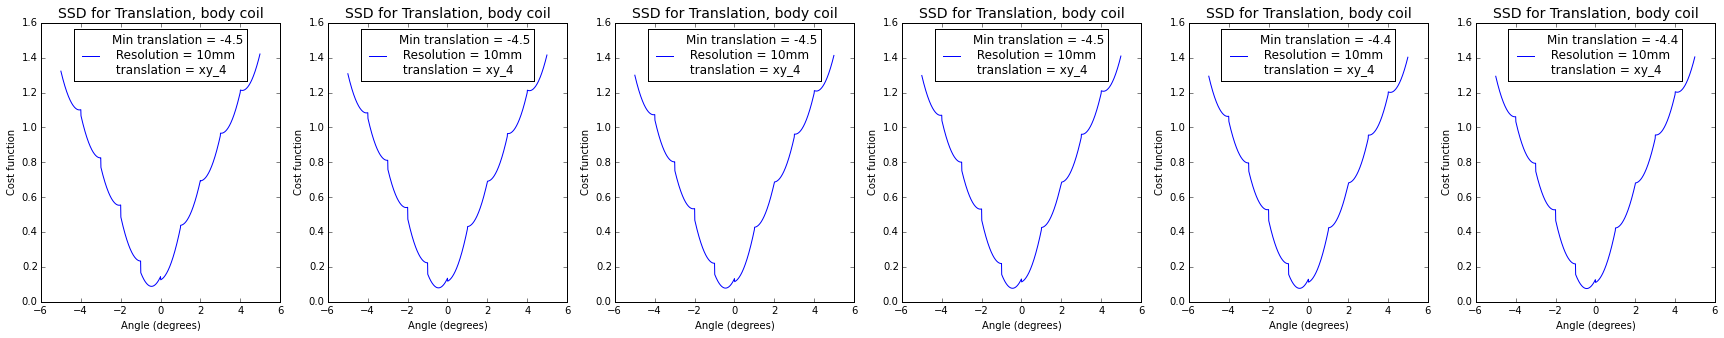

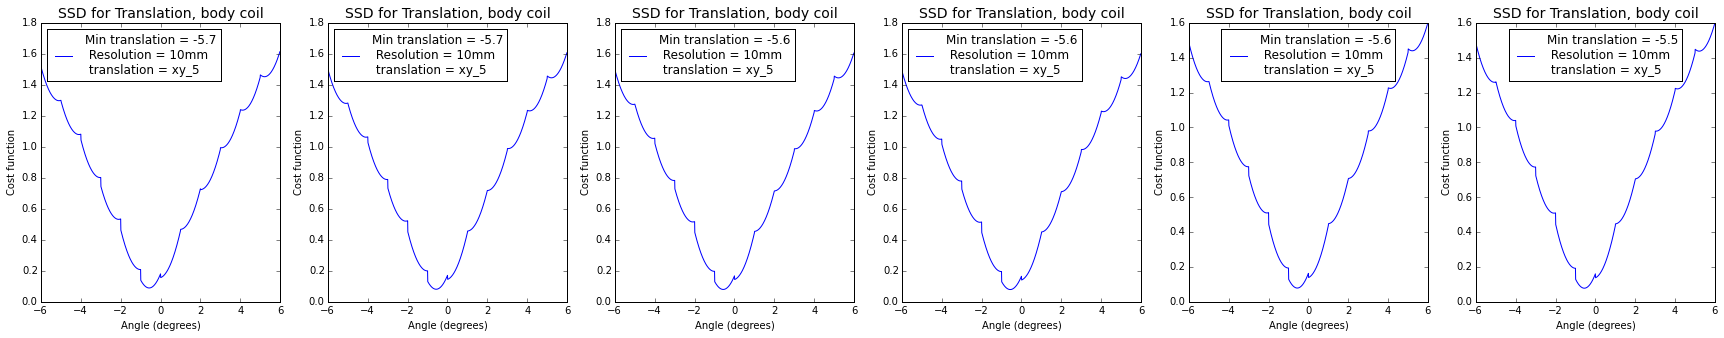

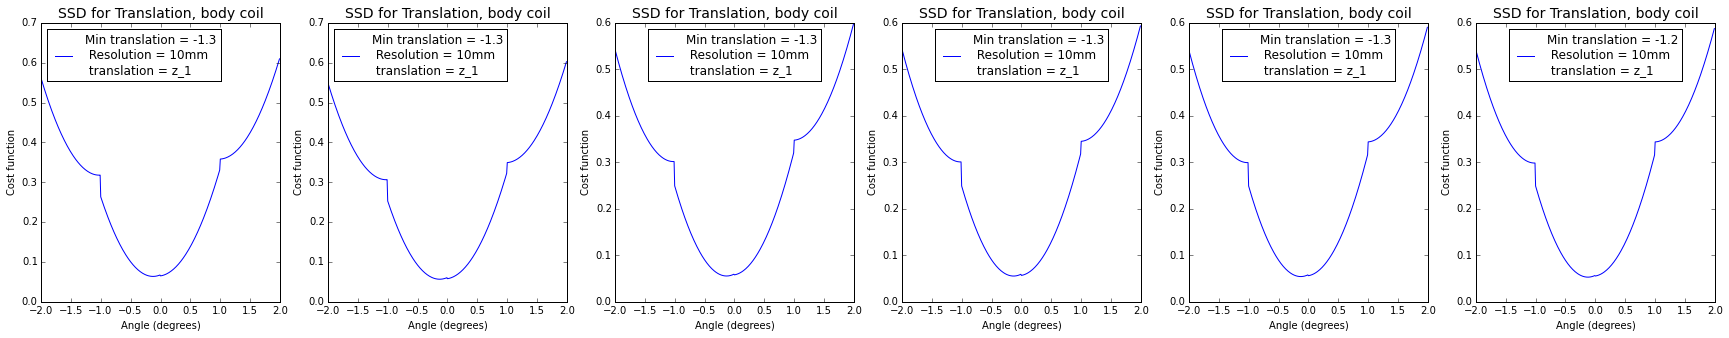

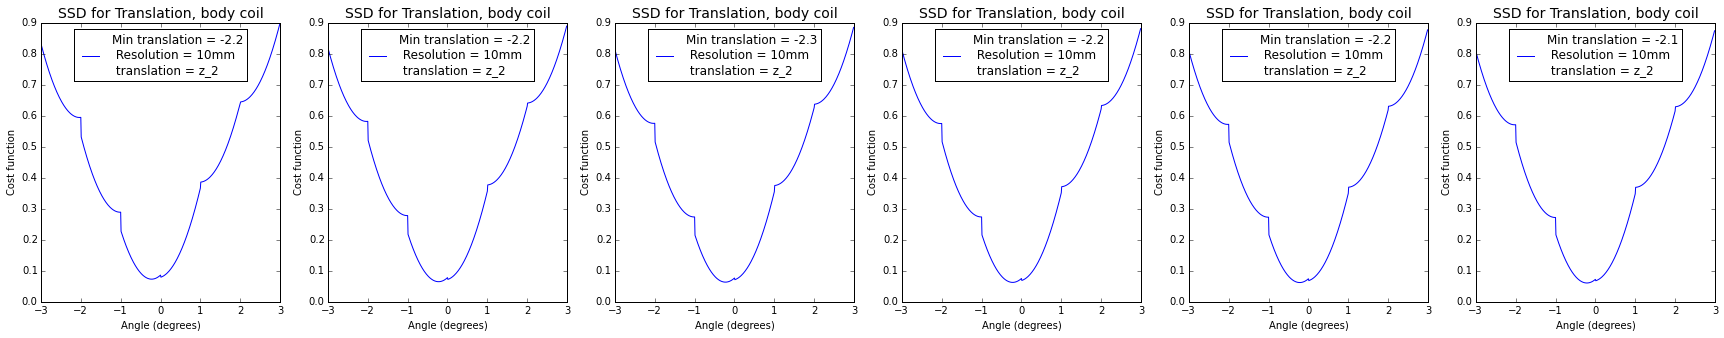

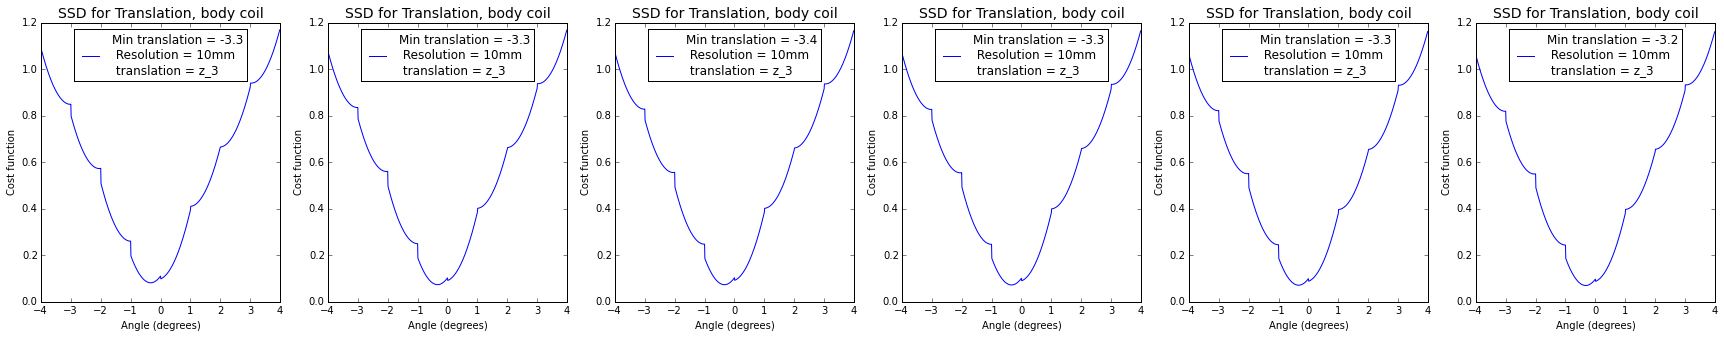

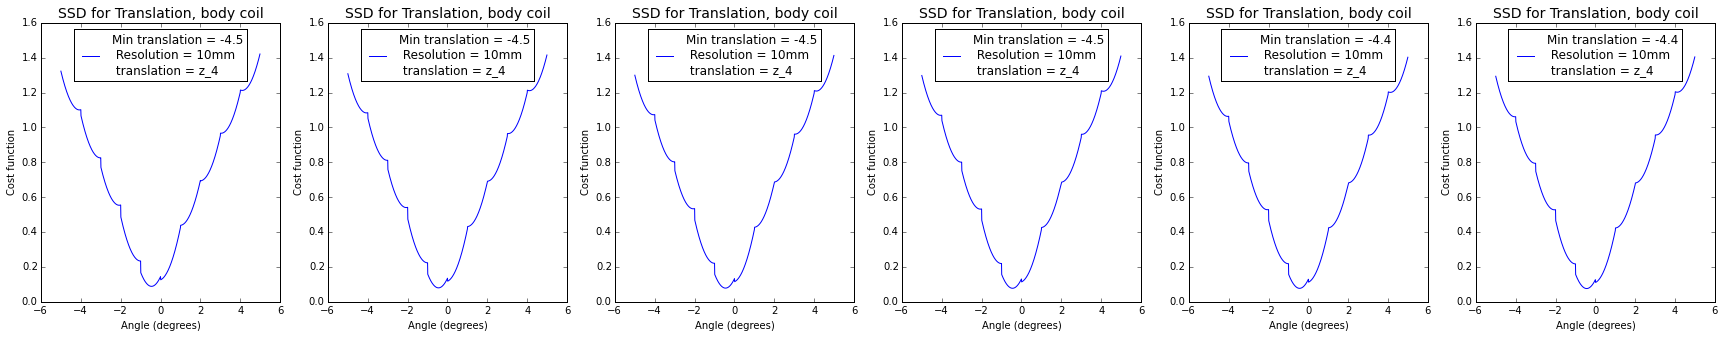

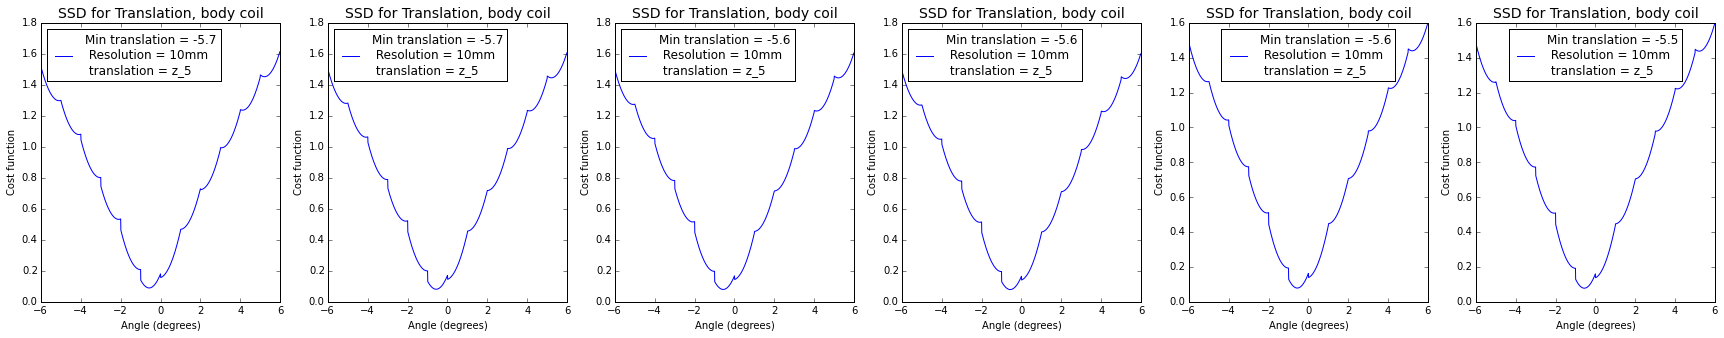

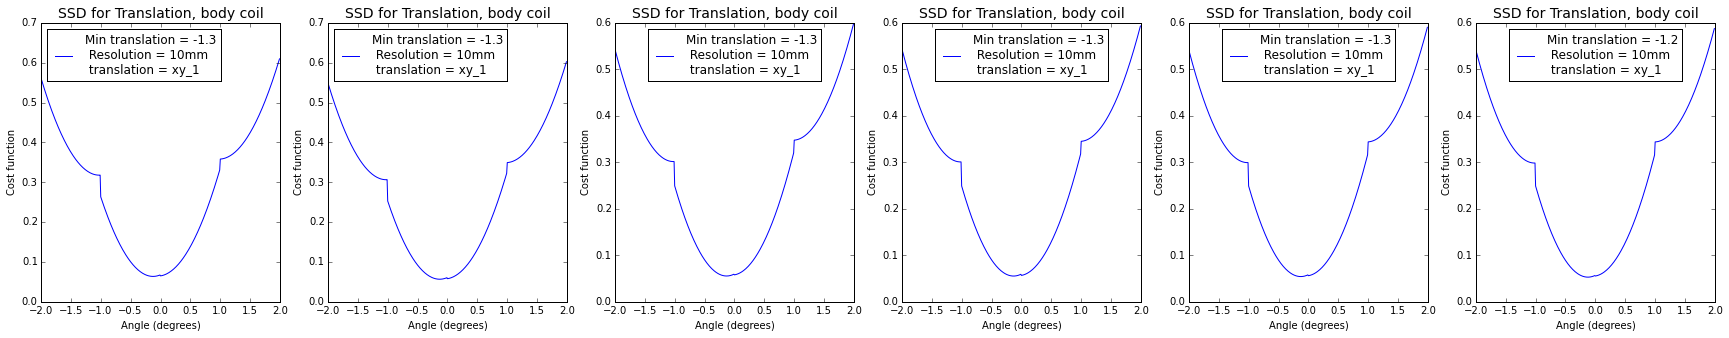

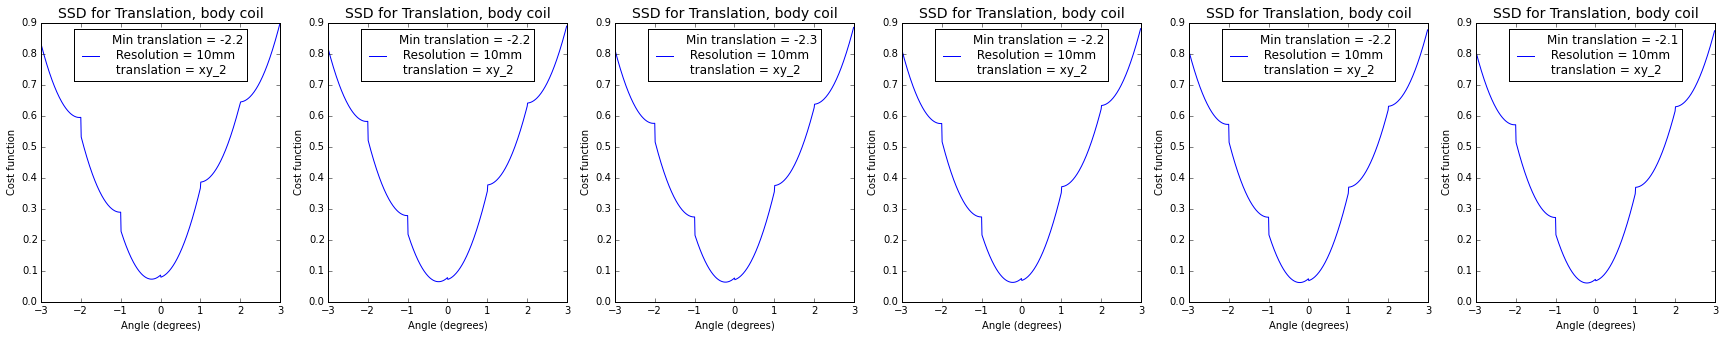

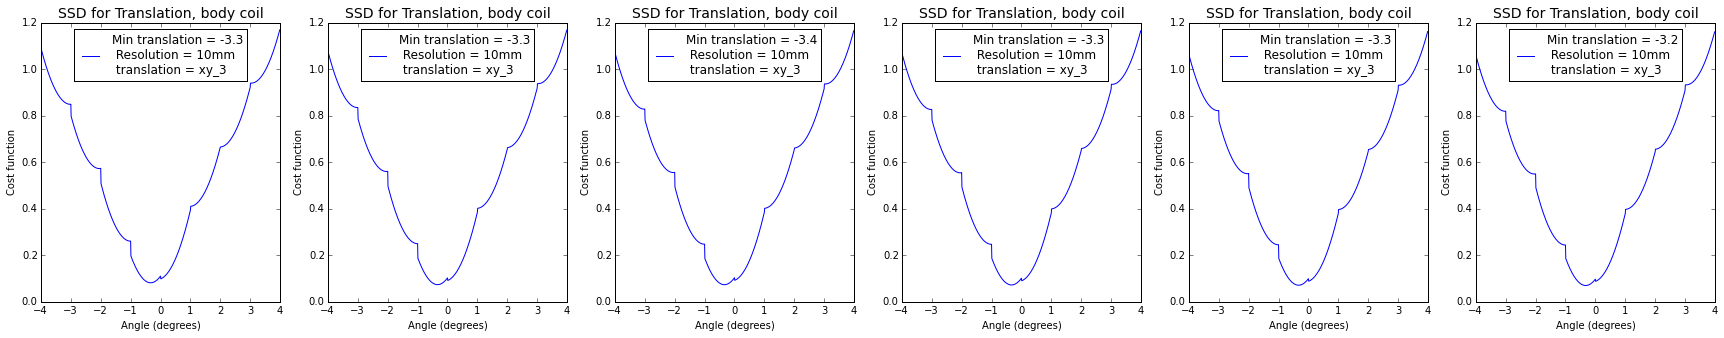

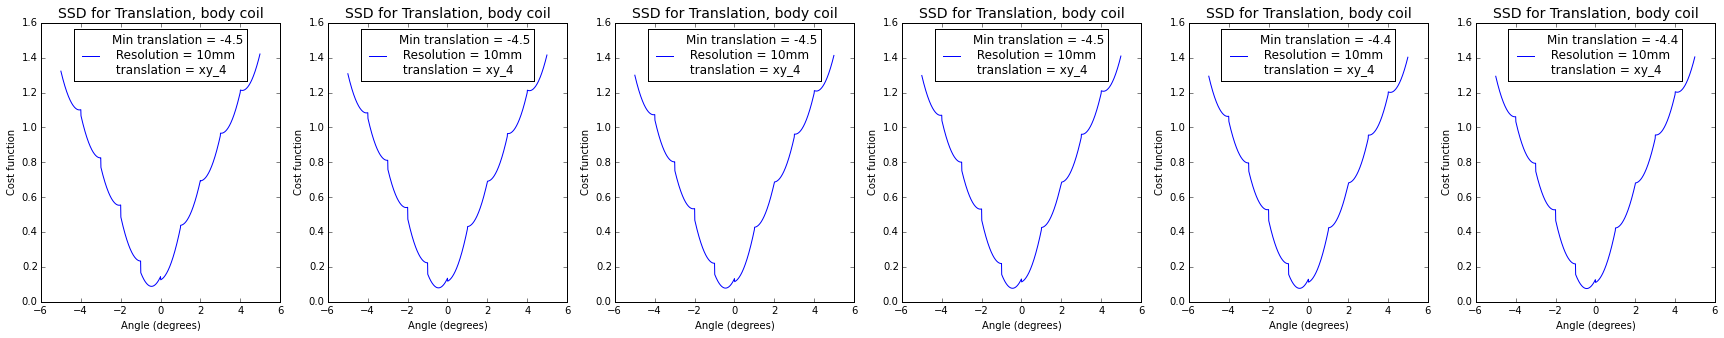

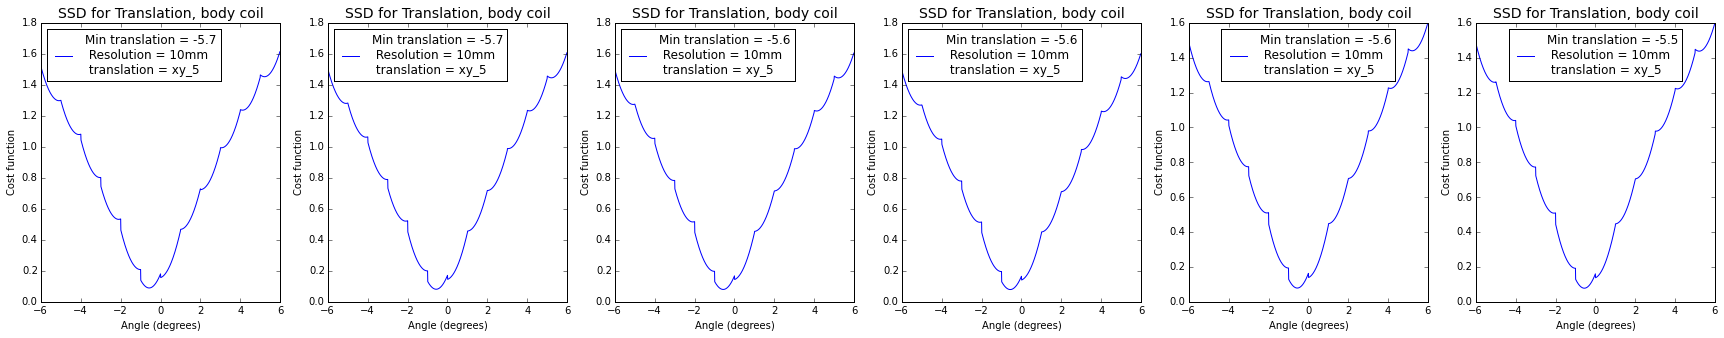

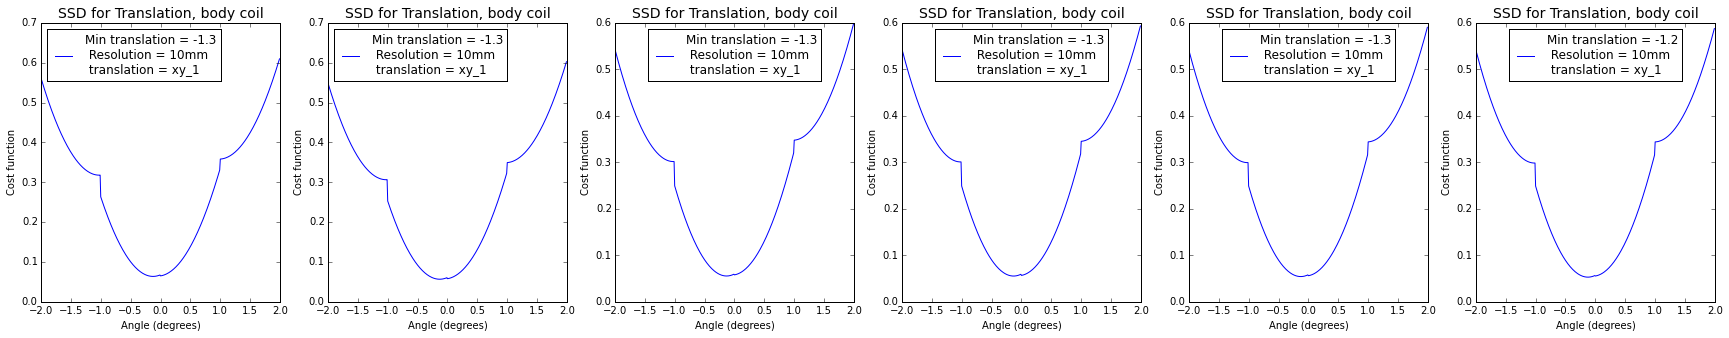

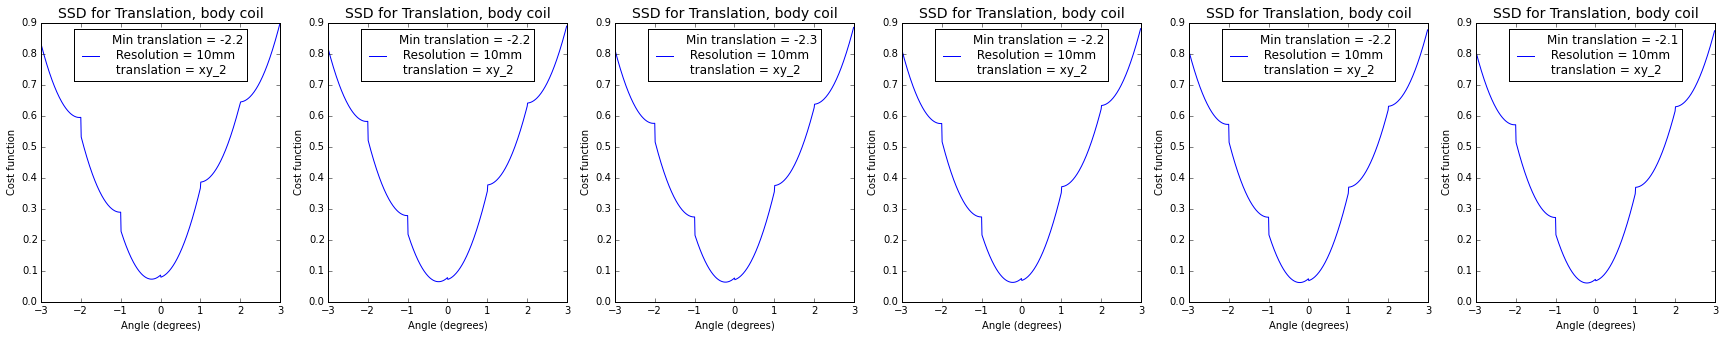

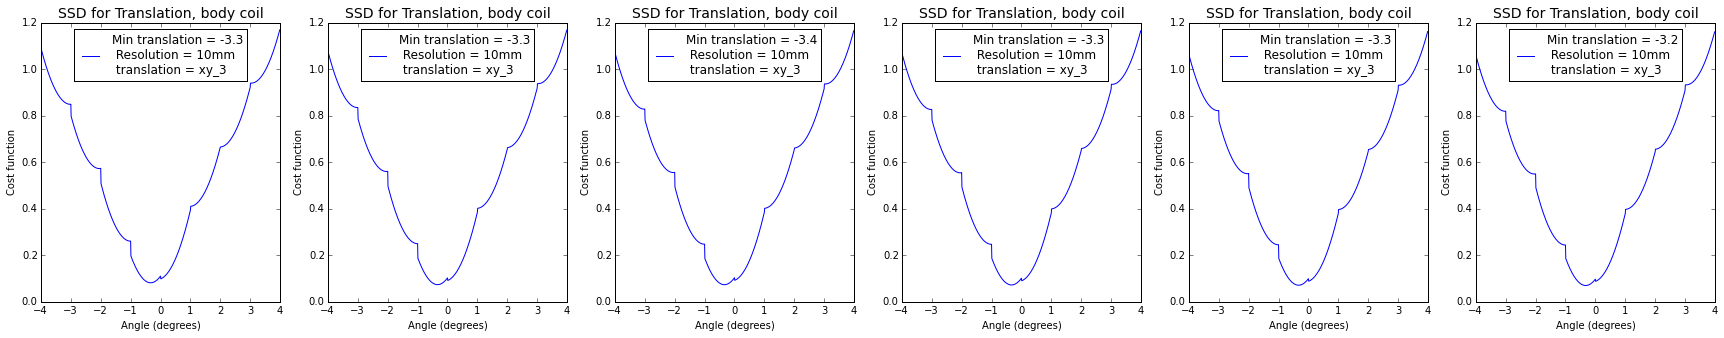

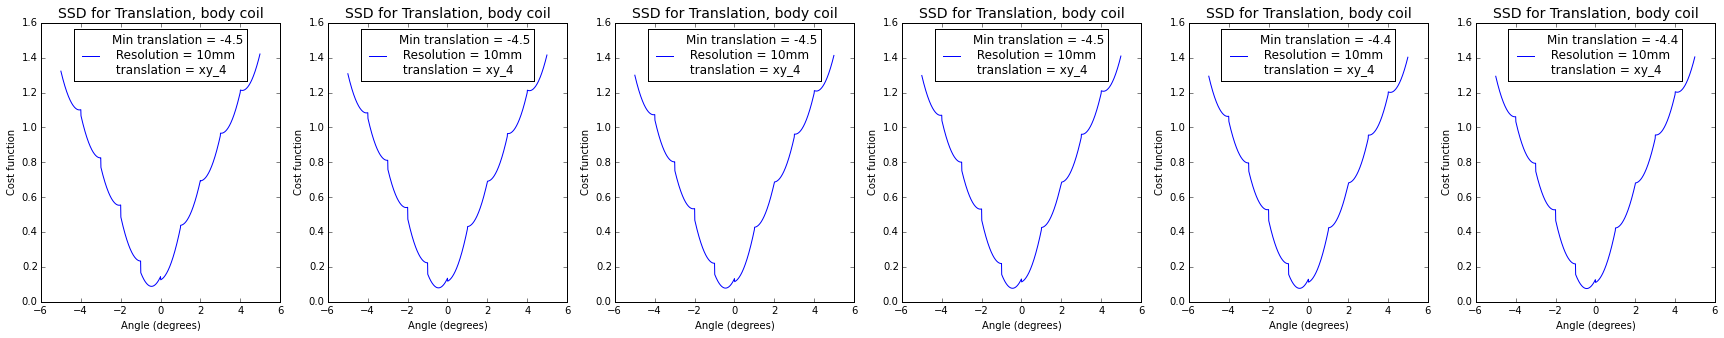

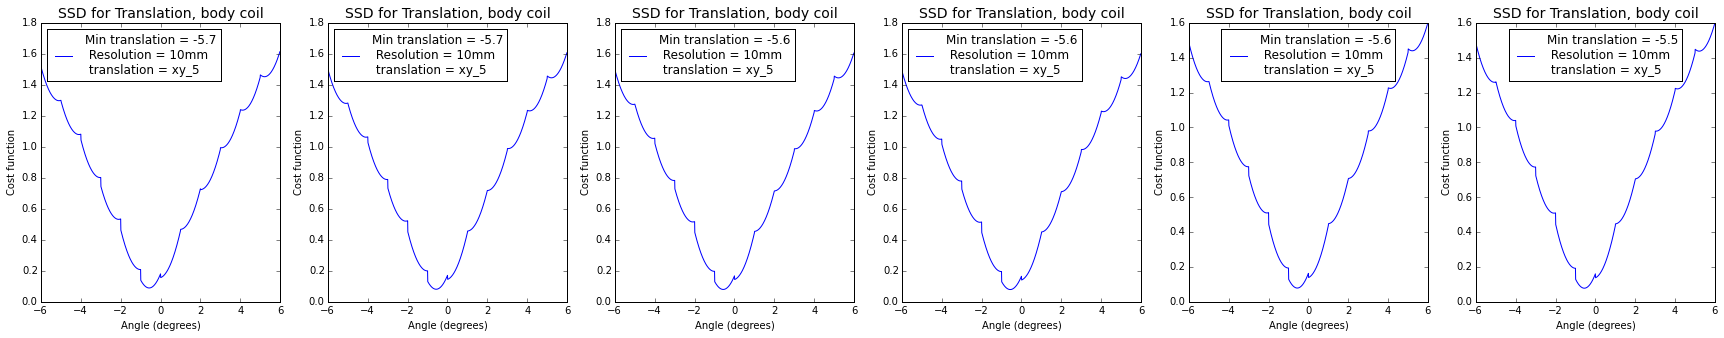

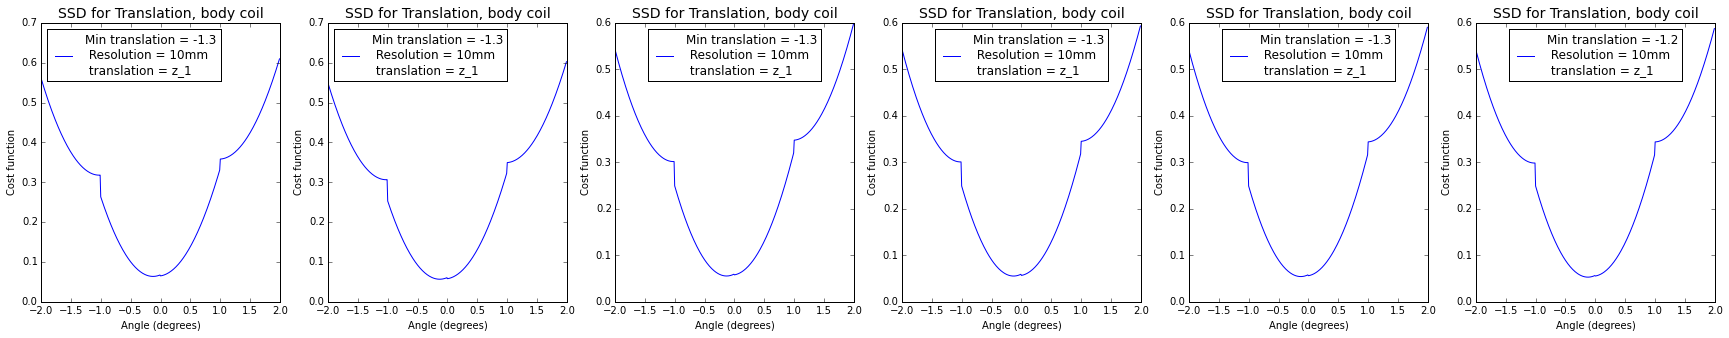

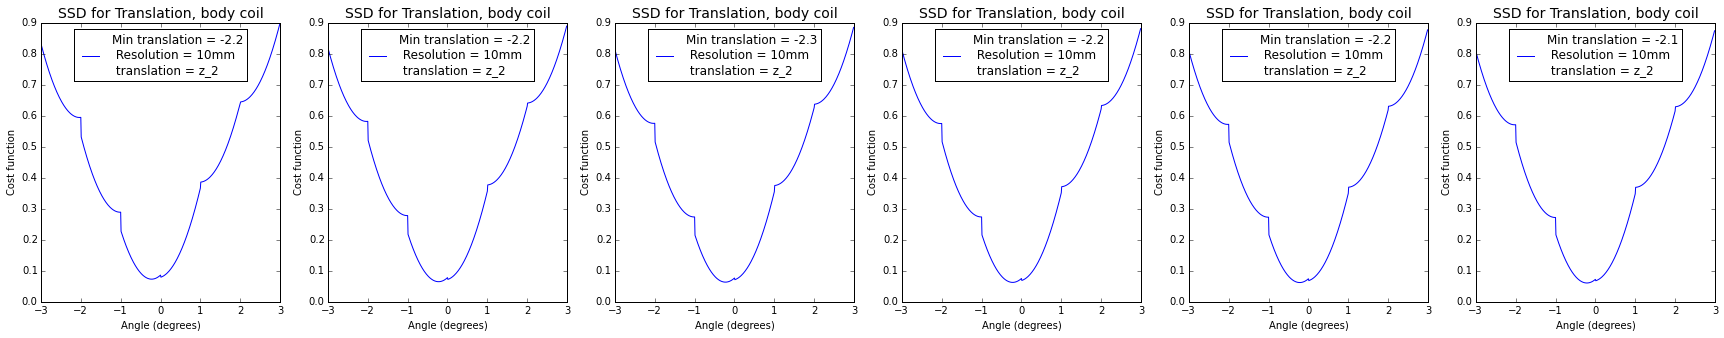

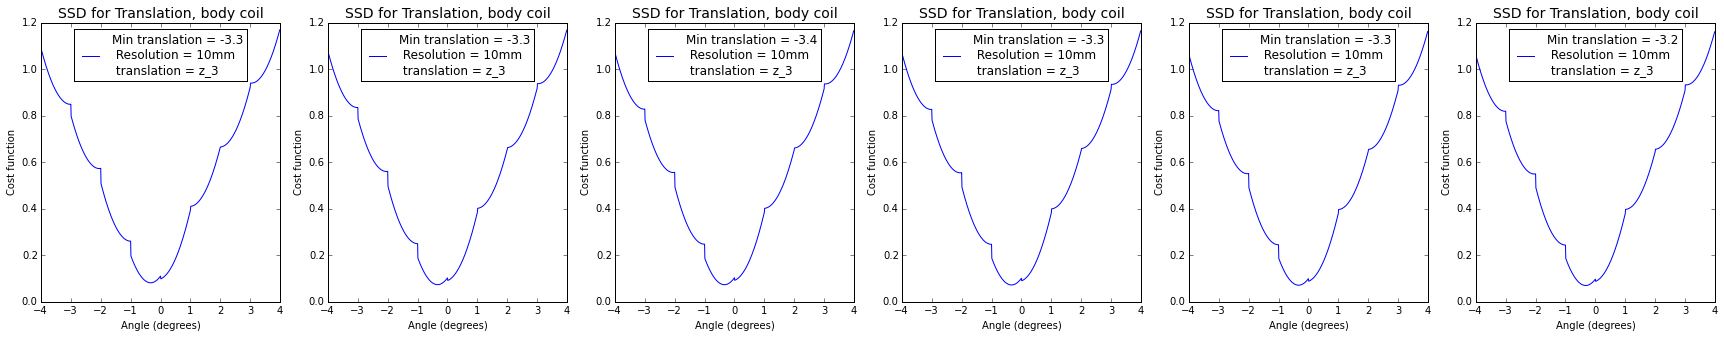

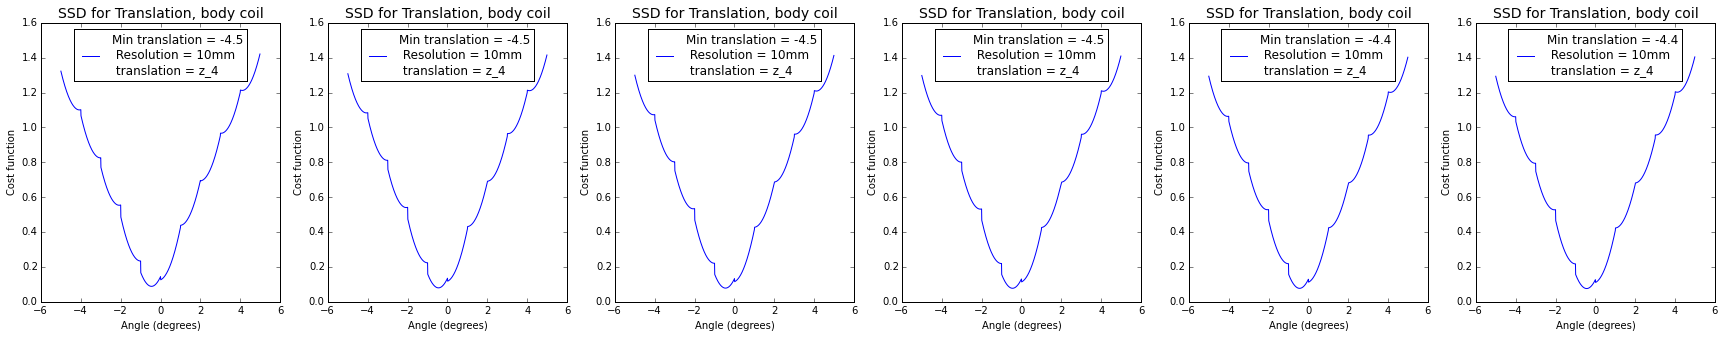

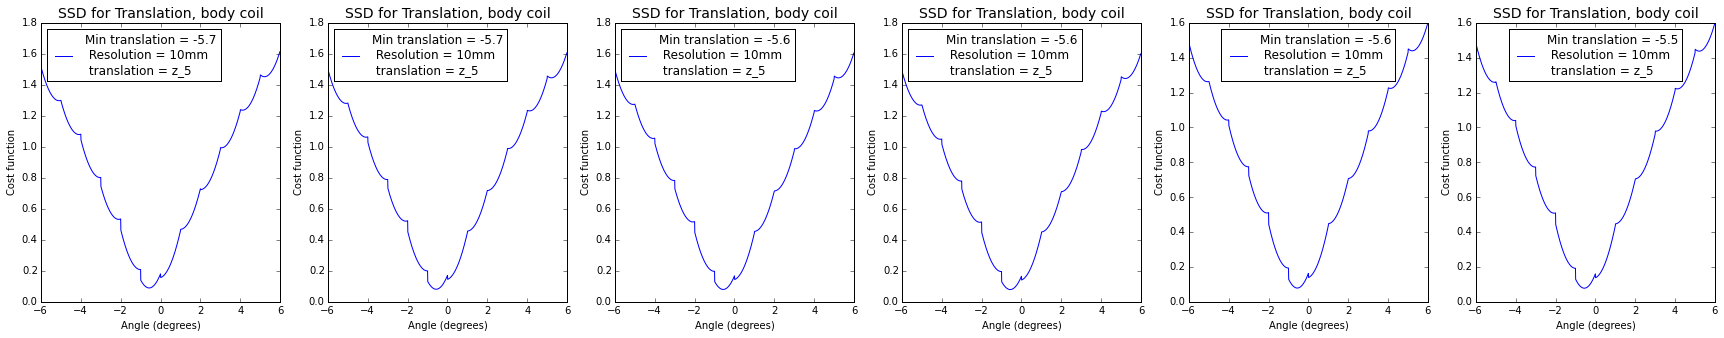

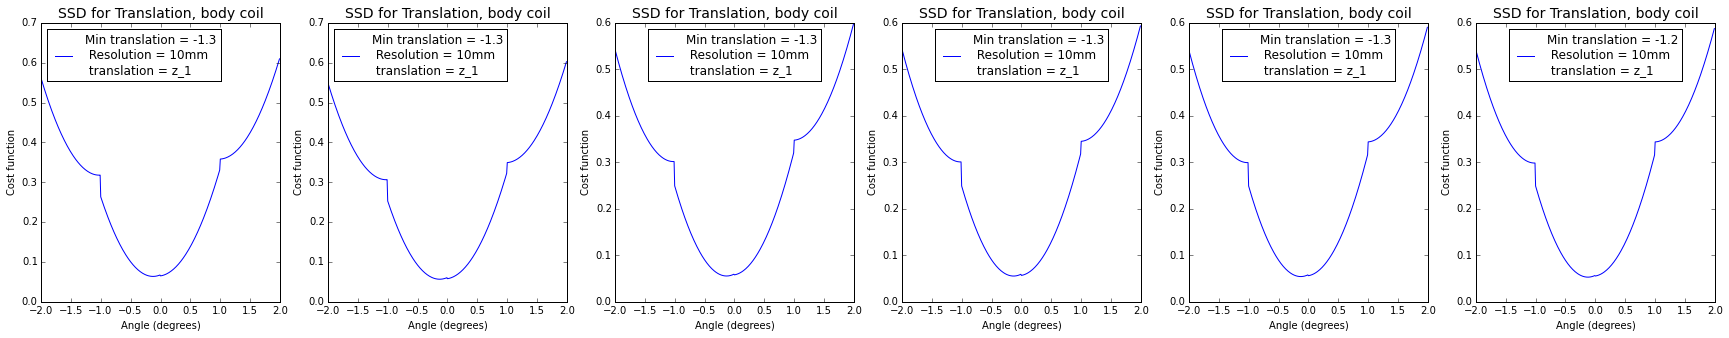

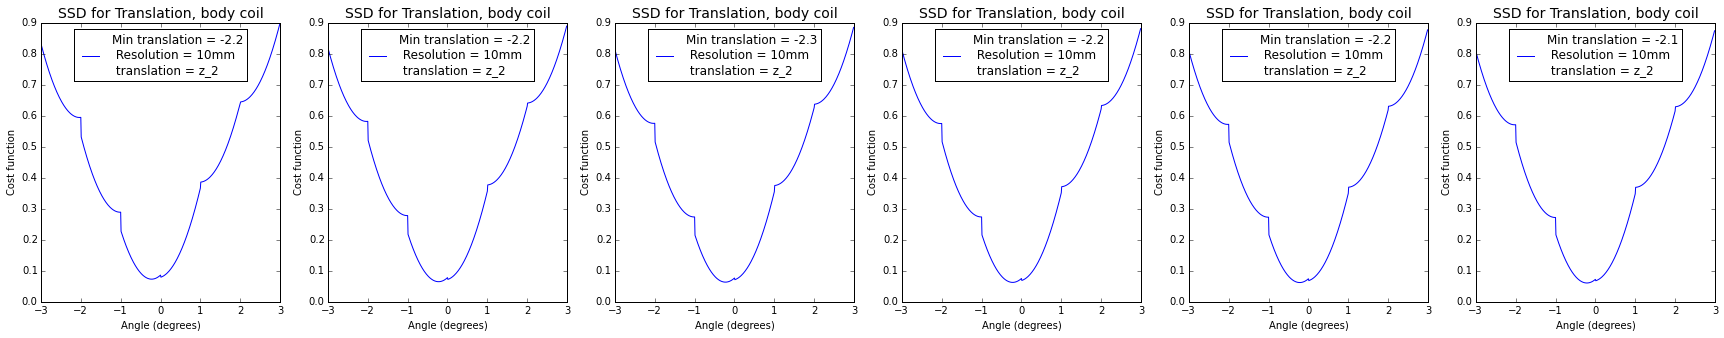

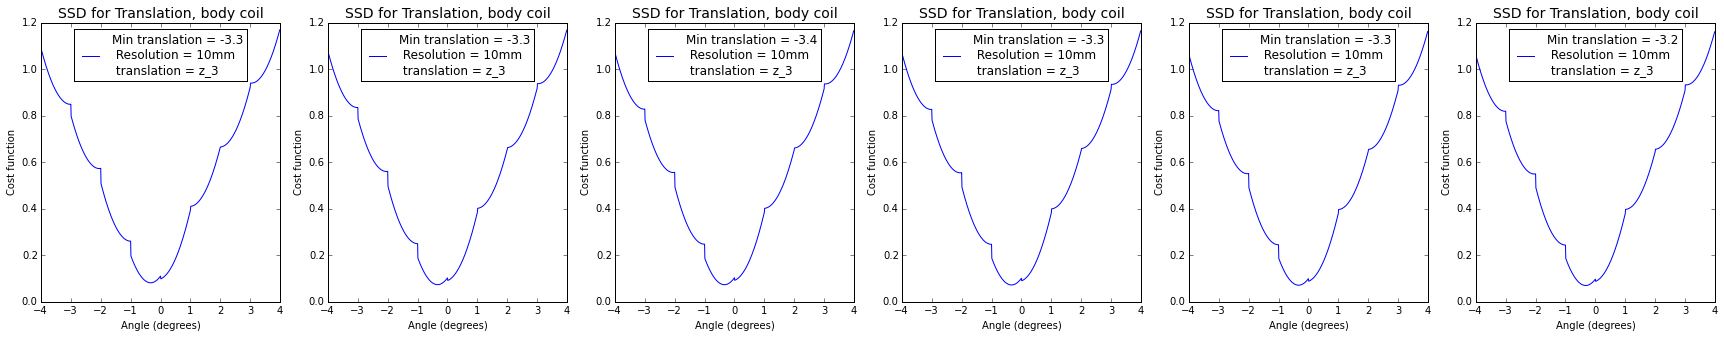

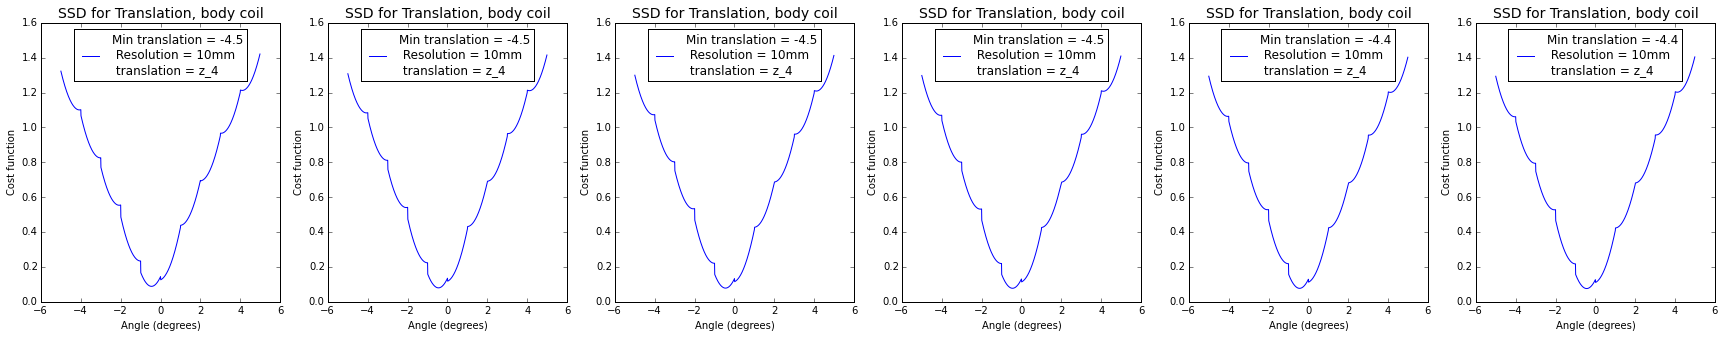

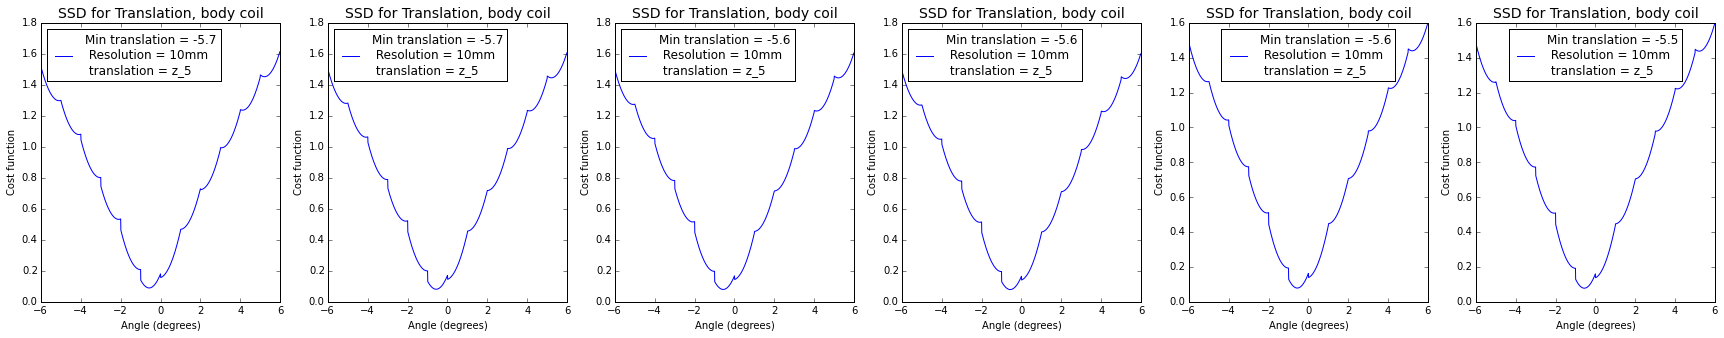

In [176]:
for k,v in axes_dict.iteritems():
    for loop in xrange(1,6):
        plt.figure(figsize = [30,5])
        for i in xrange(6):
            rep = i + loop * 6
            rot_angle = rep_to_angle(rep,rot_range)
            step = rot_angle[1]
            trans = np.arange(-step-1,step+1,0.01)
            #print v,step
            plt.subplot(1,6,i+1)
            plot_cost_func_t(trans,cost_t[rot_angle],'10mm', v+'_'+str(step))
        plt.show()

# Quarternions

In [7]:
def Hamilton_product(a1, b1, c1, d1, a2, b2, c2, d2):
    a = a1*a2-b1*b2-c1*c2-d1*d2
    i = a1*b2+b1*a2+c1*d2-d1*c2
    j = a1*c2-b1*d2+c1*a2+d1*b2
    k = a1*d2+b1*c2-c1*b2+d1*a2
    return a, i, j, k

def rotate_coords_quaternion(theta, ui, uj, uk, x, y, z):
    """
    Return the position of rotated point about quaternion u by theta degrees
    """
    ox = oy = oz = 15.5
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    
    # convert degrees to radians
    theta = to_radian(theta)
    qr = np.cos(theta/2.)
    s = np.sin(theta/2.)
    
    # coefficients for q and q^-1
    a1 = qr
    b1 = ui*s
    c1 = uj*s
    d1 = uk*s

    # calculate q*p*q^-1
    qp_a1, qp_b1, qp_c1, qp_d1 = Hamilton_product(a1,b1,c1,d1,0,x,y,z)
    
    # calculate final coordinates
    a, b, c, d = Hamilton_product(qp_a1, qp_b1, qp_c1, qp_d1,a1,-b1,-c1,-d1)
    
    return b + ox, c + oy, d + oz

In [8]:
from rotation_3d import trilinear_interp, tricubic_interp
def rotate_coords_quaternion(theta, ui, uj, uk, x, y, z):
    """
    Return the position of rotated point about quaternion u by theta degrees
    """
    ox = oy = oz = 15.5
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    
    # convert degrees to radians
    theta = to_radian(theta)
    qr = np.cos(theta/2.)
    s = np.sin(theta/2.)
    
    # coefficients for q and q^-1
    a1 = qr
    b1 = ui*s
    c1 = uj*s
    d1 = uk*s

    # calculate q*p*q^-1
    qp_a1, qp_b1, qp_c1, qp_d1 = Hamilton_product(a1,b1,c1,d1,0,x,y,z)
    
    # calculate final coordinates
    a, b, c, d = Hamilton_product(qp_a1, qp_b1, qp_c1, qp_d1,a1,-b1,-c1,-d1)
    
    return b + ox, c + oy, d + oz

def volrotate_quaternion(volume, theta, ui, uj, uk,interpolation = 'trilinear'):
    """
    Rotate a given volume by theta degrees about the unit quarternion u
    """
    # Make sure ui, uj, uk makes a unit quarternion
    if (ui**2 + uj**2 + uk**2 != 1):
        norm = np.sqrt(ui**2 + uj**2 + uk**2)
        ui = ui/norm
        uj = uj/norm
        uk = uk/norm
    
    shape = volume.shape
    # find center of the volume
    ox = shape[1]/2.-0.5
    oy = shape[0]/2.-0.5
    oz = shape[2]/2.-0.5
    
    if(shape[0] == 26): res = '10mm'
    elif(shape[0] == 32): res = '8mm'
    else: res = '6_4mm'
    xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
    
    dest_x, dest_y, dest_z = rotate_coords_quaternion(theta, ui, uj, uk, xx, yy, zz)
    if(interpolation == 'trilinear'):
        dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    if(interpolation == 'tricubic'):
        n = shape[0]
        dest = np.empty([n,n,n])
        for i in xrange(shape[0]):
            for j in xrange(shape[1]):
                for k in xrange(shape[2]):
                    dest[i,j,k] = tricubic_interp(volume,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k])
    return dest

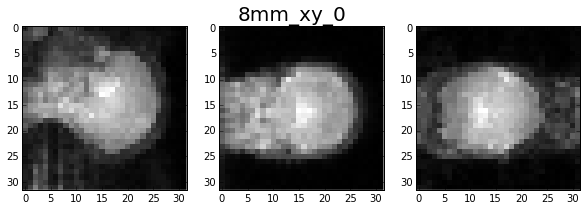

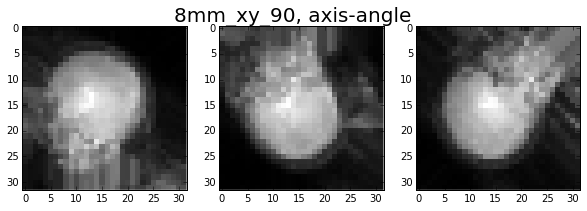

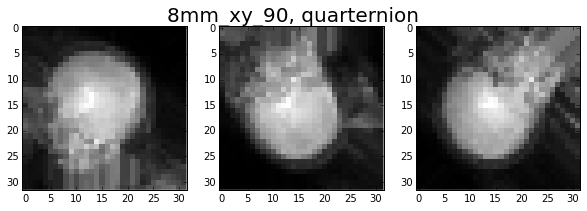

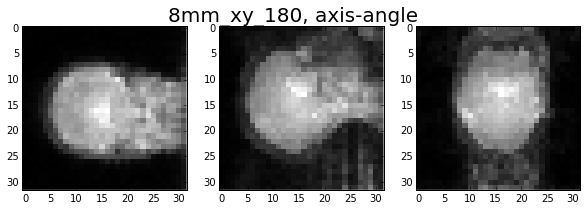

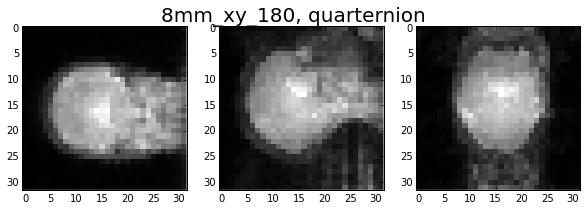

In [36]:
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
plot_volume(testVol1,'8mm','xy_0')
plot_volume(volrotate(testVol1,90,1,1,0),'8mm','xy_90, axis-angle')
plot_volume(volrotate_quaternion(testVol1,90,1,1,0),'8mm','xy_90, quarternion')
plot_volume(volrotate(testVol1,180,1,1,0),'8mm','xy_180, axis-angle')
plot_volume(volrotate_quaternion(testVol1,180,1,1,0),'8mm','xy_180, quarternion')

## Converting among Rotation Matrix, Quarternions, and Axis Angle Representation.

### Rotation Matrix
Spatial rotation can be represented in many ways. Rotation matrix representation consists of a multiplication of three basic roation, which is a rotation about one of the axes of a Coordinate system. Rotation matrix in 3D: 
$$
R_x(\theta) = \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \theta &  -\sin \theta \\[3pt]
0 & \sin \theta  &  \cos \theta \\[3pt]
\end{bmatrix}, R_y(\theta) = \begin{bmatrix}
\cos \theta & 0 & \sin \theta \\[3pt]
0 & 1 & 0 \\[3pt]
-\sin \theta & 0 & \cos \theta \\
\end{bmatrix}, R_z(\theta) = \begin{bmatrix}
\cos \theta &  -\sin \theta & 0 \\[3pt]
\sin \theta & \cos \theta & 0\\[3pt]
0 & 0 & 1\\
\end{bmatrix}$$

Multiplying the three rotation matrices defined above gives the rotation matrix representation of a 3D spatial rotation.

$$\begin{align}
R &= R_z(\alpha)\, R_y(\beta) \, R_x(\gamma)\,\!\\
&= \begin{bmatrix}
\cos \alpha &  -\sin \alpha & 0 \\
\sin \alpha & \cos \alpha & 0\\
0 & 0 & 1\\
\end{bmatrix}
\cdot \begin{bmatrix}
\cos \beta & 0 & \sin \beta \\
0 & 1 & 0 \\
-\sin \beta & 0 & \cos \beta \\
\end{bmatrix} \cdot \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \gamma &  -\sin \gamma \\[3pt]
0 & \sin \gamma  &  \cos \gamma \\[3pt]
\end{bmatrix}\\
&= \begin{bmatrix}
\cos \alpha \cos\beta & -\sin\alpha \cos\gamma+\sin\beta \cos\alpha \sin\gamma & \sin\alpha \sin\gamma + \sin\beta \cos\alpha \cos\gamma\\
\sin \alpha \cos\beta & \cos\alpha \cos\gamma+\sin\beta \sin\alpha \sin\gamma & -\cos\alpha\sin\gamma + \sin\beta \sin\alpha \cos\gamma\\
-\sin\beta & \cos\beta \sin\gamma & \cos\beta \cos\gamma\\
\end{bmatrix}
\end{align}$$

###  Quarternions
Any rigid body rotation can be represented by a single rotation by a given angle $\theta$ about a fixed axis ([Quaternions in spatial rotations](http://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation)).

Let $\boldsymbol{\mathbf{i}}$, $\boldsymbol{\mathbf{j}}$, $\boldsymbol{\mathbf{k}}$ be unit vectors representing the three Cartesian axis, then any vector $(a_x, a_y, a_z)$ can be written as $a_x\boldsymbol{\mathbf{i}} + a_y\boldsymbol{\mathbf{j}} + a_z \boldsymbol{\mathbf{k}}$. We can represent the fixed axis that the rotation is about by a unit vector $\vec{u} = (u_x, u_y, u_z) = u_x\mathbf{i} + u_y\mathbf{j} + u_z\mathbf{k}$. The quaternion for the rotation of $\theta$ about this fixed axis can now be defined as 

$$\begin{align}
\mathbf{q} &= e^{\frac{\theta}{2}{(u_x\mathbf{i} + u_y\mathbf{j} + u_z\mathbf{k})}} \\
&= \cos \frac{\theta}{2} + (u_x\mathbf{i} + u_y\mathbf{j} + u_z\mathbf{k}) \sin \frac{\theta}{2} \\
&= q_r + q_i \mathbf{i} + q_j \mathbf{i} + q_k \mathbf{i}
\end{align}$$

Now, given any vector $\mathbf{p} = (p_x, p_y, p_z) = p_x\mathbf{i} + p_y\mathbf{j} + p_z\mathbf{k}$, the new position of this vector $\mathbf{p'} = (p_x′, p_y′, p_z′)$ after rotation is

$$\mathbf{p'} = \mathbf{q} \mathbf{p} \mathbf{q}^{-1}$$

### Axis-Angle Representation
Axis-angle representation is similar to quarternions. It parameterizes a spatial rotation by a unit vector $\boldsymbol{u}$ indicating the direction of an axis of rotation, and an angle $\theta$ describing the magnitude of the rotation about the axis. For any given vector $\mathbf{v}$, the rotated vector using axis-angle representation is $$\mathbf{v}_\mathrm{rot} = (\cos\theta) \mathbf{v}  + (\sin\theta) (\mathbf{u} \times \mathbf{v})
  +  (1 - \cos\theta) (\mathbf{u} \cdot \mathbf{v}) \mathbf{u}~.$$


### Conversions 
The conversion between axis-angle and quarternions is straightforward from the definition of quarternions, given a quarternion $$\begin{align}
\mathbf{q} &= q_r + q_i \mathbf{i} + q_j \mathbf{i} + q_k \mathbf{i}\\
&= \cos \frac{\theta}{2} + (u_x\mathbf{i} + u_y\mathbf{j} + u_z\mathbf{k}) \sin \frac{\theta}{2} 
\end{align}$$


where $\mathbf{u} = u_x\mathbf{i} + u_y\mathbf{j} + u_z\mathbf{k}$ is the axis, and $\theta$ is the angle in axis-angle representation.

Conversion between quarternions can be derived as follows, a quaternion rotation can be algebraically manipulated into a rotation matrix  as $$Q = \begin{bmatrix}
1 - 2 q_j^2 - 2 q_k^2 &
2 (q_i q_j - q_k q_r) &
2 (q_i q_k + q_j q_r) \\
2 (q_i q_j + q_k q_r) &
1 - 2 q_i^2 - 2 q_k^2 &
2 (q_j q_k - q_i q_r) \\
2 (q_i q_k - q_j q_r) &
2 (q_j q_k + q_i q_r) &
1 - 2 q_i^2 - 2 q_j^2
\end{bmatrix}$$ 

Hence given a rotation matrix R from three angles $\alpha,\beta, \gamma$ along x, y, z respectively, $q_r, q_i, q_j, q_k$ can be solved from the system of equations. 

$$\begin{align}
q_i &= \frac{1}{2}\left(\sqrt{\frac{1-R_{2,2}+R_{0,1}+R_{1,0}}{2}} - \sqrt{\frac{1-R_{0,0}+R_{1,2}+R_{2,1}}{2}} + \sqrt{\frac{1-R_{1,1}+R_{0,2}+R_{2,0}}{2}}\right)\\
q_j &= \frac{1}{2}\left( \sqrt{\frac{1-R_{0,0}+R_{1,2}+R_{2,1}}{2}} - \sqrt{\frac{1-R_{1,1}+R_{0,2}+R_{2,0}}{2}}+\sqrt{\frac{1-R_{2,2}+R_{0,1}+R_{1,0}}{2}}\right)\\
q_k &= \frac{1}{2}\left( \sqrt{\frac{1-R_{0,0}+R_{1,2}+R_{2,1}}{2}} + \sqrt{\frac{1-R_{1,1}+R_{0,2}+R_{2,0}}{2}} - \sqrt{\frac{1-R_{2,2}+R_{0,1}+R_{1,0}}{2}}\right)\\
w &= \frac{R_{1,0}-R_{0,1}}{4q_k} = \frac{R_{0,2}-R_{2,0}}{4q_j} = \frac{R_{2,1}-R_{1,2}}{4q_i}
\end{align}$$

Given a quarternion, we can first construct the rotation matrix $Q$ from the quarternions, then the three angles  $\alpha,\beta, \gamma$  can be solved from $Q$. 
$$\begin{align*}
\alpha &= \arctan \left(\frac{Q_{1,0}}{Q_{0,0}}\right)\\
\beta &= \arcsin(-Q_{2,0})\\
\gamma &= \arctan \left(\frac{Q_{2,1}}{Q_{2,2}}\right)
\end{align*}$$

In [298]:
from rotation_3d import rotation_matrix_zyx,rotation_matrix_fromq
from rotation_3d import volrotate_trilinear_matrix,volrotate_trilinear,volrotate_tricubic

In [299]:
# get axis-angle representation from rotation matrix
def rotation_matrix_to_q(gamma, beta, alpha):
    
    R_ravel = rotation_matrix_zyx(gamma,beta,alpha).ravel()
    a = np.sqrt((1-R_ravel[0]+R_ravel[5]+R_ravel[7])/2)
    b = np.sqrt((1-R_ravel[4]+R_ravel[6]+R_ravel[2])/2)
    c = np.sqrt((1-R_ravel[8]+R_ravel[3]+R_ravel[1])/2)
    x = (c-a+b)/2.
    y = (a-b+c)/2.
    z = (a+b-c)/2.
    w = (R_ravel[3]-R_ravel[1])/(4.0*z)
    theta = np.arccos(w)*2
    norm = np.sin(theta/2.)
    ui = x/norm
    uj = y/norm
    uk = z/norm
    
    return theta*180/np.pi, ui, uj, uk

In [300]:
theta = 0.008727
print theta*180/np.pi
rotation_matrix_fromq(theta,1,0,1)

0.500020267811


array([[  1.00000000e+00,  -8.72688922e-03,   3.80800228e-05],
       [  8.72688922e-03,   9.99961920e-01,  -8.72688922e-03],
       [  3.80800228e-05,   8.72688922e-03,   1.00000000e+00]])

In [339]:
print rotate_coords_transformation_m(np.array([0,0,0,0,0,np.pi/2]))
print rotation_matrix_fromq(90, 0, 0, 1)

[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
[[  6.12323400e-17  -1.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   6.12323400e-17   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [340]:
print rotate_coords_transformation_m(np.array([0,0,0,0,np.pi/2,0]))
print rotation_matrix_fromq(90, 0, 1, 0)

[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
[[  6.12323400e-17   0.00000000e+00   1.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [ -1.00000000e+00   0.00000000e+00   6.12323400e-17]]


In [338]:
def rotate_coords_transformation_m(params):
    rotMatrix = np.identity(3)
    l = np.sqrt(params[3]**2+params[4]**2+params[5]**2)
    #print l,l*180/np.pi
    if(l == 0):
        return rotMatrix
    s,c = np.sin(l/2.),np.cos(l/2.)
    alpha = c
    beta = s*params[3]/l
    gamma = s*params[4]/l
    delta = s*params[5]/l

    #rotx = (alpha**2+beta**2-gamma**2-delta**2)*x+2*(beta*gamma-alpha*delta)*y+2*(beta*delta+alpha*gamma)*z+ox+params[0]
    #roty = (alpha**2-beta**2+gamma**2-delta**2)*y+2*(beta*gamma+alpha*delta)*x+2*(gamma*delta-alpha*beta)*z+oy+params[0]
    #rotz = (alpha**2-beta**2-gamma**2+delta**2)*z+2*(gamma*delta+alpha*beta)*y+2*(beta*delta-alpha*gamma)*x+oz+params[0]
    
    rotMatrix[0][0] = alpha**2+beta**2-gamma**2-delta**2
    rotMatrix[0][1] = 2*(beta*gamma-alpha*delta)
    rotMatrix[0][2] = 2*(beta*delta+alpha*gamma)

    rotMatrix[1][0] = 2*(beta*gamma+alpha*delta)
    rotMatrix[1][1] = alpha**2-beta**2+gamma**2-delta**2
    rotMatrix[1][2] = 2*(gamma*delta-alpha*beta)

    rotMatrix[2][0] = 2*(beta*delta-alpha*gamma)
    rotMatrix[2][1] = 2*(gamma*delta+alpha*beta)
    rotMatrix[2][2] = alpha**2-beta**2-gamma**2+delta**2
    return rotMatrix

In [301]:
# Get rotation matrix from axis-angle rotation
def rotation_matrix_fromq(theta, ui, uj, uk):
    '''
    theta: angle in degrees
    '''
    theta = to_radian(theta)
    c = np.cos(theta)
    s = np.sin(theta)
    rotMatrix = np.zeros([3,3])
    
    if (ui**2 + uj**2 + uk**2 != 1):
        norm = np.sqrt(ui**2 + uj**2 + uk**2)
        ui = ui/norm
        uj = uj/norm
        uk = uk/norm
        
    rotMatrix[0][0] = c + ui**2*(1-c)
    rotMatrix[0][1] = ui*uj*(1-c) - uk*s
    rotMatrix[0][2] = ui*uk*(1-c) + uj*s

    rotMatrix[1][0] = uj*ui*(1-c) + uk*s
    rotMatrix[1][1] = c + uj**2*(1-c)
    rotMatrix[1][2] = uj*uk*(1-c) - ui*s

    rotMatrix[2][0] = uk*ui*(1-c) - uj*s
    rotMatrix[2][1] = uk*uj*(1-c) + ui*s
    rotMatrix[2][2] = c + uk**2*(1-c)
    
    return rotMatrix

In [302]:
# Get the three angles of rotation give axis-angle representation
def angles_from_q(theta, ui, uj, uk):
    Q = rotation_matrix_fromq(theta, ui, uj, uk)
    alpha = np.arctan(Q[1,0]/Q[0,0])
    beta = np.arcsin(-Q[2,0])
    gamma = np.arctan(Q[2,1]/Q[2,2])
    return gamma*180/np.pi, beta*180/np.pi,  alpha*180/np.pi,

In [303]:
def rotation_matrix_zyx(gamma, beta, alpha):
    """
    Return the rotation matrix associated with counterclockwise rotation 
    about x axis by gamma degrees
    about y axis by beta degrees
    about z axis by alpha degrees
    """
    # convert degrees to radians
    gamma = to_radian(gamma)
    beta = to_radian(beta)
    alpha = to_radian(alpha)
    
    rz = np.array([[np.cos(alpha),-np.sin(alpha),0],[np.sin(alpha),np.cos(alpha),0],[0,0,1]])
    ry = np.array([[np.cos(beta),0, np.sin(beta)],[0, 1, 0],[-np.sin(beta),0,np.cos(beta)]])
    rx = np.array([[1,0,0],[0,np.cos(gamma),-np.sin(gamma)],[0,np.sin(gamma),np.cos(gamma)]])
    return (rz.dot(ry)).dot(rx)

In [304]:
# Test the conversions are correct
R = rotation_matrix_zyx(0,45,45)
R1 = rotation_matrix_fromq(*rotation_matrix_to_q(0,45,45))
np.allclose(R,R1)

True

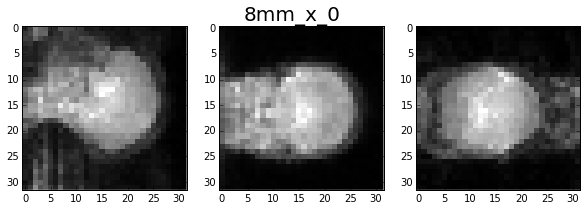

True


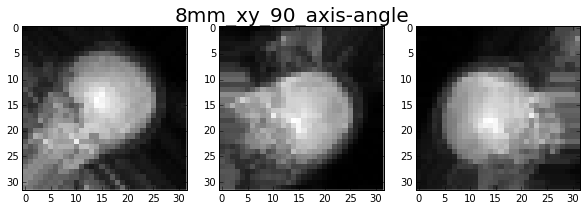

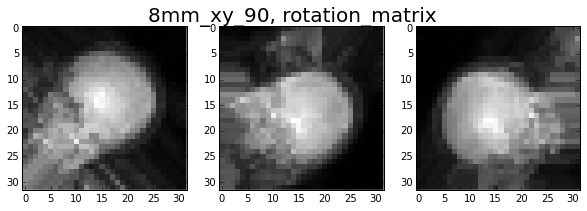

In [101]:
# Apply RyRx and then apply Rxy^ -1 check if they agree
res = '8'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol1_masked = sphere_mask(testVol1,res_to_rad(res))
plot_volume(testVol1,'8mm','x_0')

theta, ui,uj,uk = rotation_matrix_to_q(0,45,45)

rotated_matrix = volrotate_trilinear_matrix(testVol1,0,45,45,xx,yy,zz)
rotated_axis_angle = volrotate_trilinear(testVol1,theta, ui,uj,uk,xx,yy,zz)
print np.allclose(rotated_matrix,rotated_axis_angle)

plot_volume(rotated_axis_angle,'8mm','xy_90_axis-angle')
plot_volume(rotated_matrix,'8mm','xy_90, rotation_matrix')

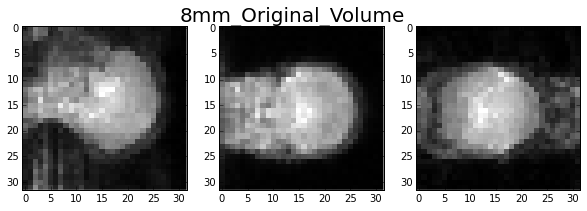

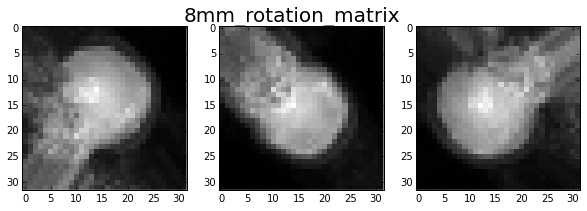

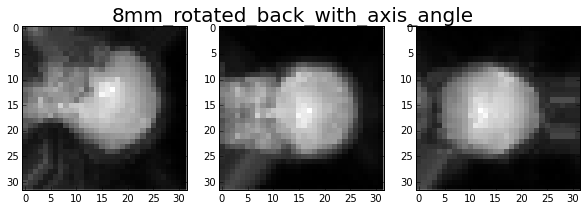

ssd between original volume and rotated back with axis angle volume: 0.148962186629


In [102]:
# Apply RyRx and then apply Rxy^ -1 check if they agree
res = '8'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

# Get a test volume
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
#testVol1 = sphere_mask(testVol1,res_to_rad(res))
plot_volume(testVol1,'8mm','Original_Volume')

# Rotate the volume around x axis for 45 degrees and then around y for 45 degrees
rotated_matrix = volrotate_trilinear_matrix(testVol1,45,45,0,xx,yy,zz)

# Now get the axis-angle representation of the 45,45,0 rotation
theta, ui,uj,uk = rotation_matrix_to_q(45,45,0)
# rotate the rotated volume by the opposite amount 
rotated_axis_angle = volrotate_trilinear(rotated_matrix,-1.*theta, ui,uj,uk,xx,yy,zz)

plot_volume(rotated_matrix,'8mm','rotation_matrix')
plot_volume(rotated_axis_angle,'8mm','rotated_back_with_axis_angle')
#
print 'ssd between original volume and rotated back with axis angle volume:', cf_ssd(testVol1, rotated_axis_angle)

In [103]:
# Get the angles from 5 degree rotation along xy
wx,wy,wz = ax_to_w('xy')
gamma, beta, alpha = angles_from_q(5,wx,wy,wz)
print gamma, beta, alpha

-3.54002475736 3.53328719463 -0.109221547992


In [104]:
rz = np.array([[np.cos(alpha),-np.sin(alpha),0],[np.sin(alpha),np.cos(alpha),0],[0,0,1]])
ry = np.array([[np.cos(beta),0, np.sin(beta)],[0, 1, 0],[-np.sin(beta),0,np.cos(beta)]])
#rx = np.array([[1,0,0],[0,np.cos(gamma),-np.sin(gamma)],[0,np.sin(gamma),np.cos(gamma)]])
R_zy = rz.dot(ry)
R_zy

array([[-0.91875604,  0.10900452, -0.37948038],
       [ 0.1007489 ,  0.99404125,  0.04161304],
       [ 0.38175516,  0.        , -0.92426349]])

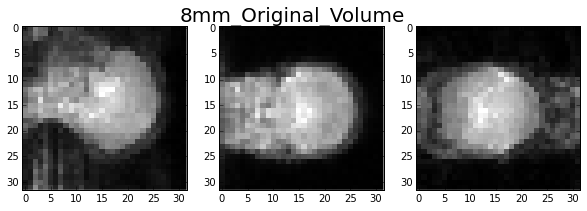

z 9.73561031725, y 30.0, x 35.2643896828


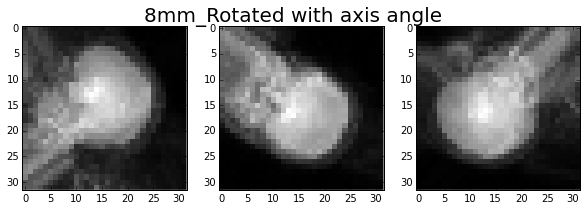

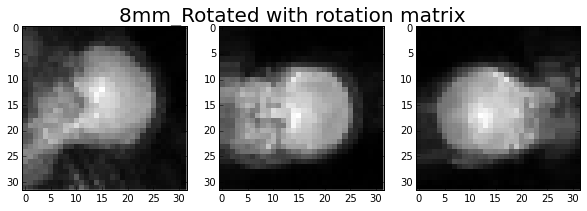

ssd between two rotated volume: 1.13164078437


In [128]:
from rotation_3d import rot_cost_func_3d
res = '8'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

# Get a test volume
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
plot_volume(testVol1,'8mm','Original_Volume')

# Rotate the original volume with axis-angle representation around (ai,aj,ak) for angle degrees
angle = 45
ai,aj,ak = 1,1,0
rotated_axis_angle = volrotate_trilinear(testVol1,angle,ai,aj,ak,xx,yy,zz)

# get the angles from axis-angle representation
gamma, beta, alpha = angles_from_q(angle,ai,aj,ak)
print 'z %s, y %s, x %s' % (alpha, beta, gamma)

# Rotate the original volume around z for gamma, y for beta degrees
rotated_matrix = volrotate_trilinear_matrix(testVol1,0, beta, alpha,xx,yy,zz)
plot_volume(rotated_axis_angle,'8mm','Rotated with axis angle')
plot_volume(rotated_matrix,'8mm','Rotated with rotation matrix')
print 'ssd between two rotated volume:', cf_ssd(rotated_axis_angle, rotated_matrix) 

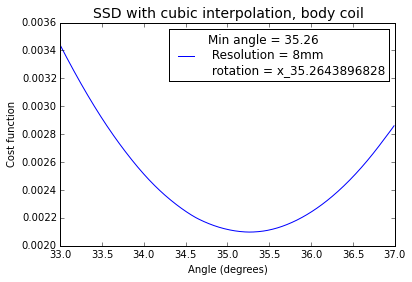

In [137]:
# Now register rotated_axis_angle with rotated_matrix, answer should be around x for gamma degrees
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(int(gamma)-2,int(gamma)+2,0.01)
#rot_ax = 'z'
#wx,wy,wz = ax_to_w(rot_ax)
wx,wy,wz = 1,0,0
cost = rot_cost_func_3d(sphere_mask(rotated_axis_angle,rad), sphere_mask(rotated_matrix,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'cubic','%s_%s'%(rot_ax,gamma), 'body')

In [146]:
from rotation_3d import get_tricubic_cache,volrotate_tricubic,volrotate_tricubic_matrix

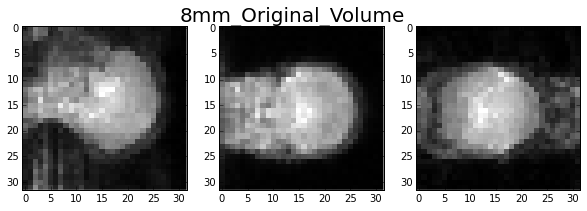

z 9.73561031725, y 30.0, x 35.2643896828


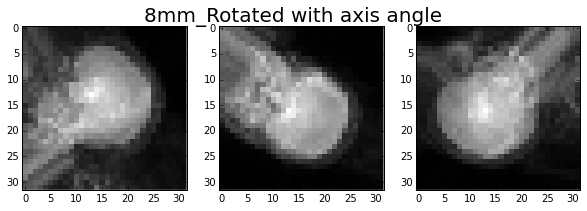

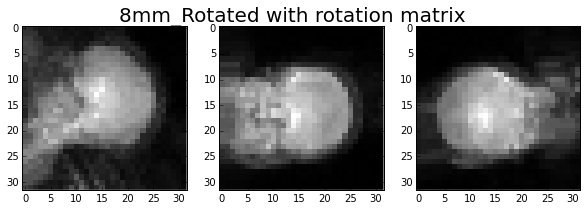

ssd between two rotated volume: 1.31069034492


In [149]:
# Do the same thing as above with tricubic interpolation
res = '8'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

# Get a test volume
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol1_cache = get_tricubic_cache(testVol1)
plot_volume(testVol1,'8mm','Original_Volume')

# Rotate the original volume with axis-angle representation around (ai,aj,ak) for angle degrees
angle = 45
ai,aj,ak = 1,1,0
rotated_axis_angle = volrotate_tricubic(testVol1.shape,testVol1_cache,angle,ai,aj,ak,xx,yy,zz)

# get the angles from axis-angle representation
gamma, beta, alpha = angles_from_q(angle,ai,aj,ak)
print 'z %s, y %s, x %s' % (alpha, beta, gamma)

# Rotate the original volume around z for gamma, y for beta degrees
rotated_matrix = volrotate_tricubic_matrix(testVol1.shape,testVol1_cache,0, beta, alpha,xx,yy,zz)
plot_volume(rotated_axis_angle,'8mm','Rotated with axis angle')
plot_volume(rotated_matrix,'8mm','Rotated with rotation matrix')
print 'ssd between two rotated volume:', cf_ssd(rotated_axis_angle, rotated_matrix) 

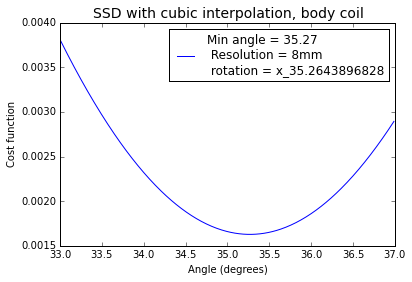

In [150]:
# Now register rotated_axis_angle with rotated_matrix, answer should be around x for gamma degrees
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(int(gamma)-1,int(gamma)+1,0.01)
#rot_ax = 'z'
#wx,wy,wz = ax_to_w(rot_ax)
wx,wy,wz = 1,0,0
cost = rot_cost_func_3d(sphere_mask(rotated_axis_angle,rad), sphere_mask(rotated_matrix,rad), thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_%s'%(rot_ax,gamma), 'body')